In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
T=100
dt=1
Boundary=6
signal_noise_ratio = 0.2

In [6]:
def generate_trajectory():
    x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, 1, Boundary)
    STATEs = np.zeros((T+1, 4))
    Disps = np.zeros((T, 2))
    init_state = np.array([x0[0], y0[0], init_v_rand_dir[0, 0], init_v_rand_dir[0, 1]])

    STATEs, Disps, _ = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)
    return STATEs, Disps

In [7]:
import os.path

if os.path.isfile('examples/dynamical_ball/trajectory.data'):
    trajectory_dict = torch.load('examples/dynamical_ball/trajectory.data')
    STATEs = trajectory_dict['STATEs']
    Disps = trajectory_dict['Disps']
else:
    STATEs, Disps = generate_trajectory()
    STATEs = torch.tensor(STATEs, dtype=torch.float32)
    Disps = torch.tensor(Disps, dtype=torch.float32)
    trajectory_dict = {
        'STATEs': STATEs,
        'Disps': Disps,
    }
    torch.save(trajectory_dict, 'examples/dynamical_ball/trajectory.data')

In [8]:
def generate_trajectory_trace():
    trajectory = STATEs
    displacements = Disps

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = point[:2]
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [9]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value.cpu().detach()
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value.cpu().detach()
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value.cpu().detach()
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [10]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [11]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [12]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [13]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [14]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [15]:
def generative_model(num_particles):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(bouncing_ball_step, initializer=init_bouncing_ball),
                           lambda: range(T))

In [16]:
def recognition_model(num_particles):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return init_bouncing_ball, bouncing_ball_step

In [17]:
def attach_proposals(model, num_particles):
    init_proposal, step_proposal = recognition_model(num_particles)

    init_selector = lambda m: m.name == 'InitBallDynamics'
    init_attach = lambda m: importance.Propose(m, init_proposal)
    model = model.apply(init_attach, init_selector)

    step_selector = lambda m: m.name == 'StepBallDynamics'
    step_attach = lambda m: importance.Propose(m, step_proposal)
    return model.apply(step_attach, step_selector)

In [18]:
def training_model(num_particles, inference_strategy):
    model = generative_model(num_particles)
    model = attach_proposals(model, num_particles)
    return inference_strategy(model)

In [19]:
trajectory, displacements, data = generate_trajectory_trace()

In [20]:
def train_model(num_particles, inference_strategy, inclusive_kl=False, plot_bounds=True, log_estimator=False):
    sampler = training_model(num_particles, inference_strategy)
    
    tau, params, evidence_bounds = importance.variational_importance(
        sampler, 500, data, use_cuda=True, lr=1e-1,
        inclusive_kl=inclusive_kl, patience=100,
        log_estimator=log_estimator,
    )
    
    if plot_bounds:
        utils.plot_evidence_bounds(evidence_bounds, not inclusive_kl)
    
    return sampler, tau, evidence_bounds

In [21]:
def evaluate_inference(sampler, tau):
    inferred_trajectory = accumulate_trajectory(tau)

    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([tau['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

    graph_original_trajectory(trajectory, T, 0)
    graph_inferred_trajectory(positions, T, 0)
    graph_displacement_trajectories(velocity_steps, displacements, T, 0)
    
    for t in range(T+1):
        logging.info('MSE at time %d: %s' % (t, ((data['position_%d' % t] - positions[t])**2).sum(dim=0)))

In [22]:
sample_sizes = [2, 10, 100]
SAMPLING_STRATEGIES = ['Monte Carlo importance sampling', 'Importance Weighted sampling', 'Sequential Monte Carlo']
sampling_strategies = [(lambda m: m, False), (lambda m: m, True), (lambda m: importance.smc(m), False)]
kl_directions = [False, True]

In [23]:
def experiment():
    results = {}
    for i, (inference_strategy, estimator) in enumerate(sampling_strategies):
        for inclusive_kl in kl_directions:
            for num_particles in sample_sizes:
                logging.info('Experimenting with sampling strategy: ' + SAMPLING_STRATEGIES[i])
                logging.info('Experimenting with sample size of %d', num_particles)
                logging.info('Experimenting with %s training', 'Wake-Sleep' if inclusive_kl else 'Variational')
                sampler, tau, evidence_bounds = train_model((num_particles,), inference_strategy, inclusive_kl, plot_bounds=True, log_estimator=estimator)
                evaluate_inference(sampler, tau)
                results[(SAMPLING_STRATEGIES[i], num_particles, inclusive_kl)] = (tau, evidence_bounds)
    return results

03/05/2019 12:37:16 Experimenting with sampling strategy: Monte Carlo importance sampling
03/05/2019 12:37:16 Experimenting with sample size of 2
03/05/2019 12:37:16 Experimenting with Variational training
03/05/2019 12:37:17 ELBO=-1.12676758e+03 at epoch 1
03/05/2019 12:37:17 ELBO=-5.01218628e+02 at epoch 2
03/05/2019 12:37:17 ELBO=-6.49897095e+02 at epoch 3
03/05/2019 12:37:17 ELBO=-1.04635779e+03 at epoch 4
03/05/2019 12:37:18 ELBO=-4.77157257e+02 at epoch 5
03/05/2019 12:37:18 ELBO=-6.87269104e+02 at epoch 6
03/05/2019 12:37:18 ELBO=-4.49033020e+02 at epoch 7
03/05/2019 12:37:18 ELBO=-5.24084290e+02 at epoch 8
03/05/2019 12:37:18 ELBO=-7.40605652e+02 at epoch 9
03/05/2019 12:37:18 ELBO=-4.75856995e+02 at epoch 10
03/05/2019 12:37:19 ELBO=-4.60051392e+02 at epoch 11
03/05/2019 12:37:19 ELBO=-4.89818848e+02 at epoch 12
03/05/2019 12:37:19 ELBO=-4.78020020e+02 at epoch 13
03/05/2019 12:37:19 ELBO=-4.28570251e+02 at epoch 14
03/05/2019 12:37:19 ELBO=-4.68265808e+02 at epoch 15
03/05/20

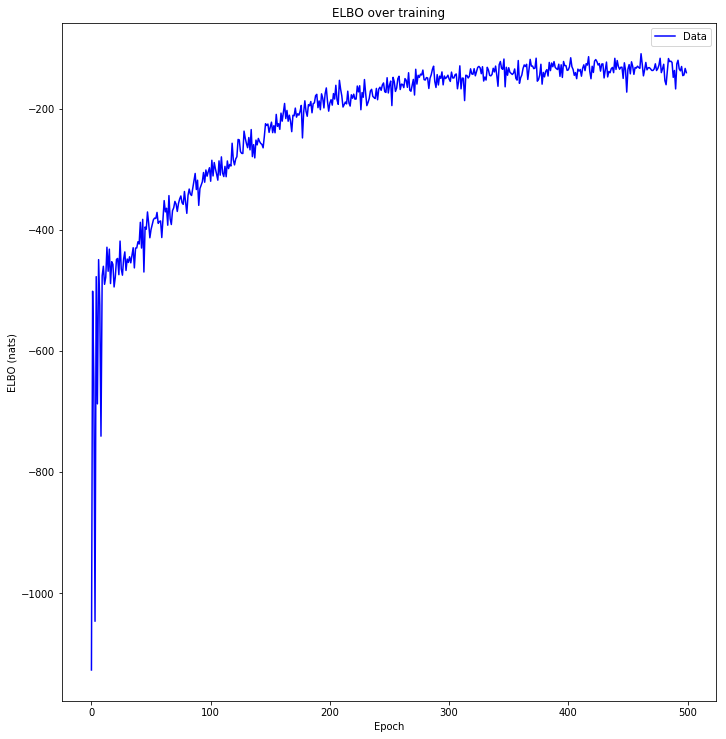

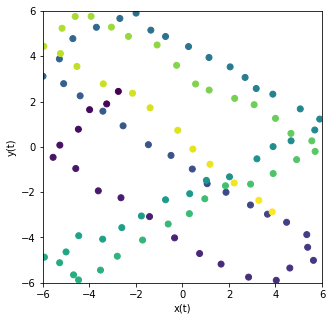

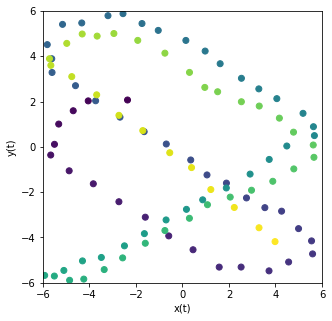

03/05/2019 12:38:47 MSE at time 0: tensor(0.2998)
03/05/2019 12:38:47 MSE at time 1: tensor(0.6477)
03/05/2019 12:38:47 MSE at time 2: tensor(0.4983)
03/05/2019 12:38:47 MSE at time 3: tensor(0.7671)
03/05/2019 12:38:47 MSE at time 4: tensor(0.0545)
03/05/2019 12:38:47 MSE at time 5: tensor(0.0207)
03/05/2019 12:38:47 MSE at time 6: tensor(0.0908)
03/05/2019 12:38:47 MSE at time 7: tensor(0.1426)
03/05/2019 12:38:47 MSE at time 8: tensor(0.0391)
03/05/2019 12:38:47 MSE at time 9: tensor(0.0339)
03/05/2019 12:38:47 MSE at time 10: tensor(0.0707)
03/05/2019 12:38:47 MSE at time 11: tensor(0.1073)
03/05/2019 12:38:47 MSE at time 12: tensor(0.0241)
03/05/2019 12:38:47 MSE at time 13: tensor(0.3009)
03/05/2019 12:38:47 MSE at time 14: tensor(0.2709)
03/05/2019 12:38:47 MSE at time 15: tensor(0.0730)
03/05/2019 12:38:47 MSE at time 16: tensor(0.0823)
03/05/2019 12:38:47 MSE at time 17: tensor(0.1075)
03/05/2019 12:38:47 MSE at time 18: tensor(0.1952)
03/05/2019 12:38:47 MSE at time 19: tenso

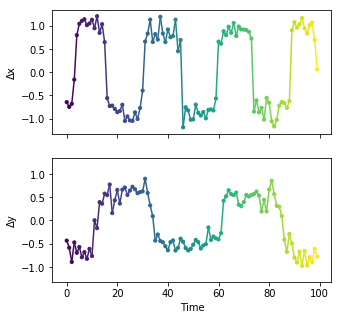

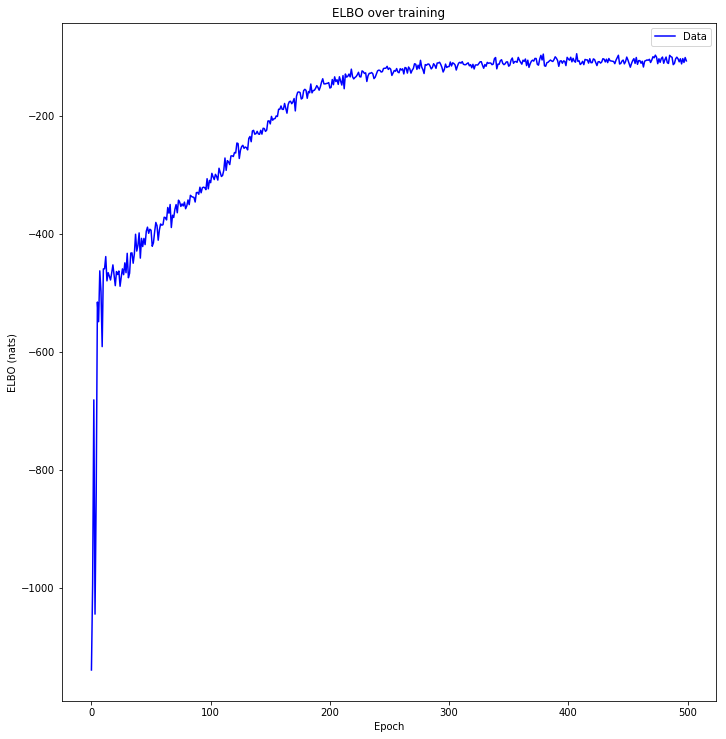

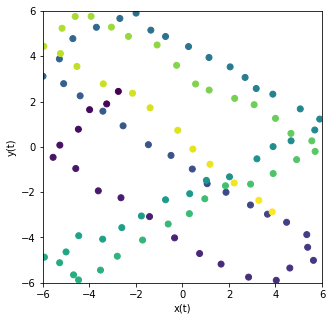

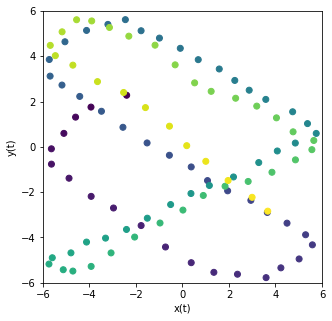

03/05/2019 12:40:20 MSE at time 0: tensor(0.1569)
03/05/2019 12:40:20 MSE at time 1: tensor(0.4757)
03/05/2019 12:40:20 MSE at time 2: tensor(0.4728)
03/05/2019 12:40:20 MSE at time 3: tensor(0.4218)
03/05/2019 12:40:20 MSE at time 4: tensor(0.1589)
03/05/2019 12:40:20 MSE at time 5: tensor(0.0959)
03/05/2019 12:40:20 MSE at time 6: tensor(0.2676)
03/05/2019 12:40:20 MSE at time 7: tensor(0.1546)
03/05/2019 12:40:20 MSE at time 8: tensor(0.3091)
03/05/2019 12:40:20 MSE at time 9: tensor(0.2876)
03/05/2019 12:40:20 MSE at time 10: tensor(0.3156)
03/05/2019 12:40:20 MSE at time 11: tensor(0.2931)
03/05/2019 12:40:20 MSE at time 12: tensor(0.2282)
03/05/2019 12:40:20 MSE at time 13: tensor(0.2447)
03/05/2019 12:40:20 MSE at time 14: tensor(0.2057)
03/05/2019 12:40:20 MSE at time 15: tensor(0.1474)
03/05/2019 12:40:20 MSE at time 16: tensor(0.3835)
03/05/2019 12:40:20 MSE at time 17: tensor(0.0529)
03/05/2019 12:40:20 MSE at time 18: tensor(0.0027)
03/05/2019 12:40:20 MSE at time 19: tenso

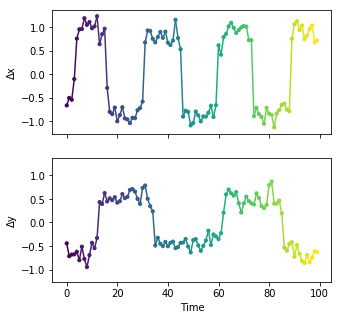

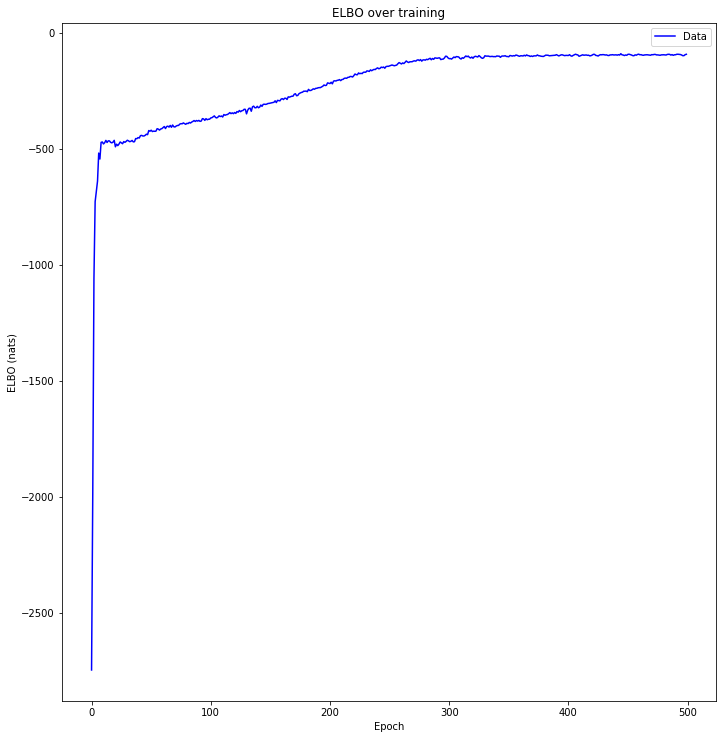

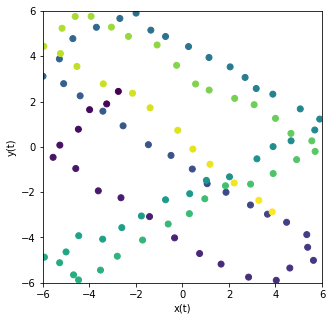

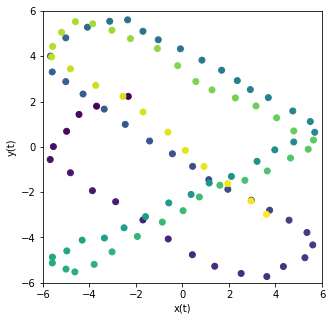

03/05/2019 12:41:49 MSE at time 0: tensor(0.2313)
03/05/2019 12:41:49 MSE at time 1: tensor(0.1992)
03/05/2019 12:41:49 MSE at time 2: tensor(0.2521)
03/05/2019 12:41:49 MSE at time 3: tensor(0.2647)
03/05/2019 12:41:49 MSE at time 4: tensor(0.0812)
03/05/2019 12:41:49 MSE at time 5: tensor(0.0250)
03/05/2019 12:41:49 MSE at time 6: tensor(0.0882)
03/05/2019 12:41:49 MSE at time 7: tensor(0.0643)
03/05/2019 12:41:49 MSE at time 8: tensor(0.0833)
03/05/2019 12:41:49 MSE at time 9: tensor(0.1031)
03/05/2019 12:41:49 MSE at time 10: tensor(0.0773)
03/05/2019 12:41:49 MSE at time 11: tensor(0.0991)
03/05/2019 12:41:49 MSE at time 12: tensor(0.0837)
03/05/2019 12:41:49 MSE at time 13: tensor(0.1289)
03/05/2019 12:41:49 MSE at time 14: tensor(0.1921)
03/05/2019 12:41:49 MSE at time 15: tensor(0.0805)
03/05/2019 12:41:49 MSE at time 16: tensor(0.1472)
03/05/2019 12:41:49 MSE at time 17: tensor(0.0592)
03/05/2019 12:41:49 MSE at time 18: tensor(0.0087)
03/05/2019 12:41:49 MSE at time 19: tenso

Epoch   101: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 12:42:05 EUBO=5.84522188e-12 at epoch 104
03/05/2019 12:42:05 EUBO=1.15442756e-16 at epoch 105
03/05/2019 12:42:06 EUBO=8.18589101e-19 at epoch 106
03/05/2019 12:42:06 EUBO=-0.00000000e+00 at epoch 107
03/05/2019 12:42:06 EUBO=1.00363068e-05 at epoch 108
03/05/2019 12:42:06 EUBO=6.06571091e-20 at epoch 109
03/05/2019 12:42:06 EUBO=7.31780251e-13 at epoch 110
03/05/2019 12:42:06 EUBO=-0.00000000e+00 at epoch 111
03/05/2019 12:42:07 EUBO=2.50725464e-07 at epoch 112
03/05/2019 12:42:07 EUBO=5.39930165e-02 at epoch 113
03/05/2019 12:42:07 EUBO=5.82226813e-02 at epoch 114
03/05/2019 12:42:07 EUBO=-0.00000000e+00 at epoch 115
03/05/2019 12:42:07 EUBO=1.51337201e-08 at epoch 116
03/05/2019 12:42:07 EUBO=1.98516132e-28 at epoch 117
03/05/2019 12:42:08 EUBO=9.81509270e-28 at epoch 118
03/05/2019 12:42:08 EUBO=4.69059384e-19 at epoch 119
03/05/2019 12:42:08 EUBO=8.08713640e-18 at epoch 120
03/05/2019 12:42:08 EUBO=5.91954930e-10 at epoch 121
03/05/2019 12:42:08 EUBO=1.12177264e-15 at 

Epoch   202: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 12:42:21 EUBO=1.00708008e+02 at epoch 205
03/05/2019 12:42:21 EUBO=3.02021217e-04 at epoch 206
03/05/2019 12:42:21 EUBO=2.09501556e+02 at epoch 207
03/05/2019 12:42:21 EUBO=1.79757202e+02 at epoch 208
03/05/2019 12:42:21 EUBO=7.80933142e-01 at epoch 209
03/05/2019 12:42:21 EUBO=6.31857291e-20 at epoch 210
03/05/2019 12:42:21 EUBO=3.78082184e-11 at epoch 211
03/05/2019 12:42:22 EUBO=7.01347735e-09 at epoch 212
03/05/2019 12:42:22 EUBO=5.96175385e+00 at epoch 213
03/05/2019 12:42:22 EUBO=9.45925471e-09 at epoch 214
03/05/2019 12:42:22 EUBO=5.72184557e-11 at epoch 215
03/05/2019 12:42:22 EUBO=1.54767559e-08 at epoch 216
03/05/2019 12:42:22 EUBO=5.32365322e+00 at epoch 217
03/05/2019 12:42:22 EUBO=2.02806551e-21 at epoch 218
03/05/2019 12:42:23 EUBO=5.55061065e-02 at epoch 219
03/05/2019 12:42:23 EUBO=1.00585090e-07 at epoch 220
03/05/2019 12:42:23 EUBO=1.57782316e+00 at epoch 221
03/05/2019 12:42:23 EUBO=6.60158008e-08 at epoch 222
03/05/2019 12:42:23 EUBO=2.03027360e-15 at epo

Epoch   303: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 12:42:36 EUBO=5.76751481e-04 at epoch 306
03/05/2019 12:42:36 EUBO=2.72861961e-03 at epoch 307
03/05/2019 12:42:36 EUBO=1.03834259e-06 at epoch 308
03/05/2019 12:42:36 EUBO=3.07277603e+01 at epoch 309
03/05/2019 12:42:36 EUBO=1.22656958e-04 at epoch 310
03/05/2019 12:42:36 EUBO=2.83864574e-05 at epoch 311
03/05/2019 12:42:37 EUBO=3.58446522e-10 at epoch 312
03/05/2019 12:42:37 EUBO=1.14896011e+01 at epoch 313
03/05/2019 12:42:37 EUBO=5.14925690e+01 at epoch 314
03/05/2019 12:42:37 EUBO=7.54870300e+01 at epoch 315
03/05/2019 12:42:37 EUBO=1.95668792e-09 at epoch 316
03/05/2019 12:42:37 EUBO=1.70714378e-01 at epoch 317
03/05/2019 12:42:38 EUBO=3.33185387e+01 at epoch 318
03/05/2019 12:42:38 EUBO=1.93848663e+02 at epoch 319
03/05/2019 12:42:38 EUBO=3.50202731e-06 at epoch 320
03/05/2019 12:42:38 EUBO=8.39827135e-06 at epoch 321
03/05/2019 12:42:38 EUBO=4.19743545e-03 at epoch 322
03/05/2019 12:42:38 EUBO=1.90862045e+02 at epoch 323
03/05/2019 12:42:39 EUBO=9.44436761e-06 at epo

Epoch   404: reducing learning rate of group 0 to 6.2500e-03.


03/05/2019 12:42:52 EUBO=2.29201869e-05 at epoch 407
03/05/2019 12:42:53 EUBO=1.58305350e-03 at epoch 408
03/05/2019 12:42:53 EUBO=9.10264789e-04 at epoch 409
03/05/2019 12:42:53 EUBO=1.05150707e-06 at epoch 410
03/05/2019 12:42:53 EUBO=4.66160431e+01 at epoch 411
03/05/2019 12:42:53 EUBO=1.35379963e+01 at epoch 412
03/05/2019 12:42:53 EUBO=2.42260211e-16 at epoch 413
03/05/2019 12:42:54 EUBO=1.44173864e-05 at epoch 414
03/05/2019 12:42:54 EUBO=2.15291089e-04 at epoch 415
03/05/2019 12:42:54 EUBO=1.33928070e+01 at epoch 416
03/05/2019 12:42:54 EUBO=2.30200100e-03 at epoch 417
03/05/2019 12:42:54 EUBO=7.49600449e+01 at epoch 418
03/05/2019 12:42:54 EUBO=1.49748459e+02 at epoch 419
03/05/2019 12:42:55 EUBO=1.16706390e+01 at epoch 420
03/05/2019 12:42:55 EUBO=2.85079182e-06 at epoch 421
03/05/2019 12:42:55 EUBO=1.23712937e-06 at epoch 422
03/05/2019 12:42:55 EUBO=1.73879641e-07 at epoch 423
03/05/2019 12:42:55 EUBO=2.81566391e+01 at epoch 424
03/05/2019 12:42:55 EUBO=3.63859844e+00 at epo

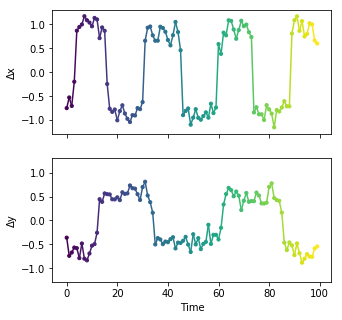

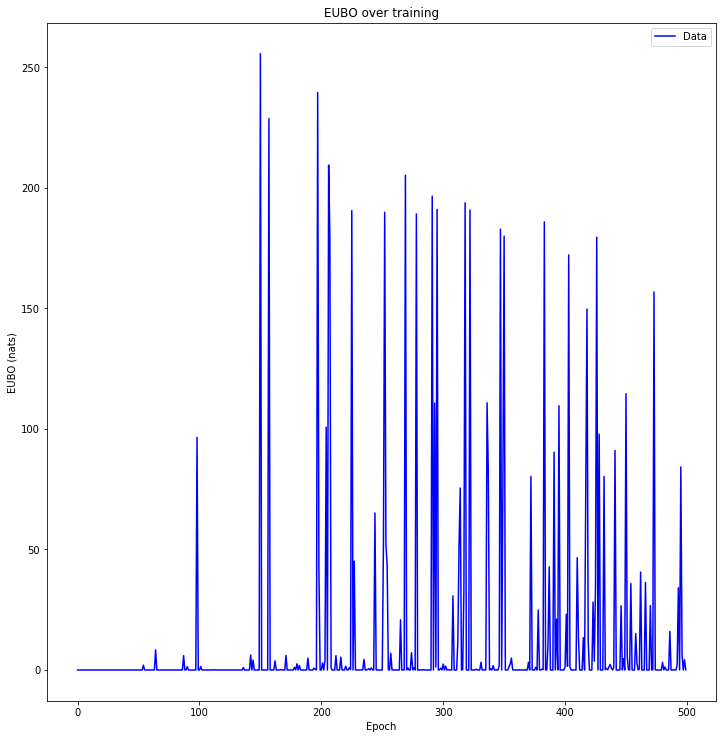

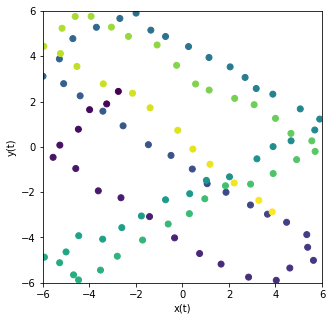

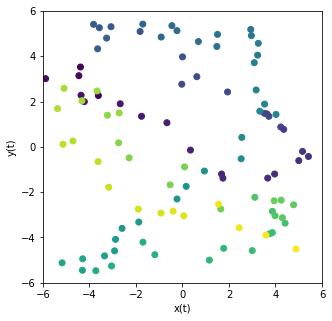

03/05/2019 12:43:08 MSE at time 0: tensor(0.7742)
03/05/2019 12:43:08 MSE at time 1: tensor(3.9259)
03/05/2019 12:43:08 MSE at time 2: tensor(2.4643)
03/05/2019 12:43:08 MSE at time 3: tensor(6.9700)
03/05/2019 12:43:08 MSE at time 4: tensor(5.6817)
03/05/2019 12:43:08 MSE at time 5: tensor(7.8510)
03/05/2019 12:43:08 MSE at time 6: tensor(11.8151)
03/05/2019 12:43:08 MSE at time 7: tensor(14.2829)
03/05/2019 12:43:08 MSE at time 8: tensor(14.8776)
03/05/2019 12:43:08 MSE at time 9: tensor(11.7221)
03/05/2019 12:43:08 MSE at time 10: tensor(12.0301)
03/05/2019 12:43:08 MSE at time 11: tensor(12.0805)
03/05/2019 12:43:08 MSE at time 12: tensor(18.4353)
03/05/2019 12:43:08 MSE at time 13: tensor(21.9810)
03/05/2019 12:43:08 MSE at time 14: tensor(28.8420)
03/05/2019 12:43:08 MSE at time 15: tensor(24.8877)
03/05/2019 12:43:08 MSE at time 16: tensor(23.3644)
03/05/2019 12:43:08 MSE at time 17: tensor(28.1554)
03/05/2019 12:43:08 MSE at time 18: tensor(31.3033)
03/05/2019 12:43:08 MSE at t

Epoch   105: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 12:43:26 EUBO=1.81254253e+01 at epoch 108
03/05/2019 12:43:27 EUBO=1.21327922e-01 at epoch 109
03/05/2019 12:43:27 EUBO=3.16608829e+01 at epoch 110
03/05/2019 12:43:27 EUBO=3.84337692e+01 at epoch 111
03/05/2019 12:43:27 EUBO=5.42861223e-02 at epoch 112
03/05/2019 12:43:27 EUBO=6.84723663e+00 at epoch 113
03/05/2019 12:43:28 EUBO=1.09211743e-01 at epoch 114
03/05/2019 12:43:28 EUBO=2.26060247e+00 at epoch 115
03/05/2019 12:43:28 EUBO=1.66579580e+00 at epoch 116
03/05/2019 12:43:28 EUBO=1.19028437e+00 at epoch 117
03/05/2019 12:43:28 EUBO=1.09682648e+02 at epoch 118
03/05/2019 12:43:28 EUBO=3.46694678e-01 at epoch 119
03/05/2019 12:43:29 EUBO=3.16962743e+00 at epoch 120
03/05/2019 12:43:29 EUBO=1.83426477e-02 at epoch 121
03/05/2019 12:43:29 EUBO=2.84034882e+01 at epoch 122
03/05/2019 12:43:29 EUBO=1.84135803e+02 at epoch 123
03/05/2019 12:43:29 EUBO=2.36445409e-03 at epoch 124
03/05/2019 12:43:29 EUBO=1.67449936e+02 at epoch 125
03/05/2019 12:43:30 EUBO=7.56591326e-04 at epo

Epoch   206: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 12:43:44 EUBO=5.18125355e-01 at epoch 209
03/05/2019 12:43:44 EUBO=5.84385757e+01 at epoch 210
03/05/2019 12:43:44 EUBO=1.79675636e+01 at epoch 211
03/05/2019 12:43:44 EUBO=7.57762603e-03 at epoch 212
03/05/2019 12:43:44 EUBO=1.76732087e+00 at epoch 213
03/05/2019 12:43:44 EUBO=2.99823074e+01 at epoch 214
03/05/2019 12:43:45 EUBO=1.08787010e+02 at epoch 215
03/05/2019 12:43:45 EUBO=9.99481888e+01 at epoch 216
03/05/2019 12:43:45 EUBO=9.49088192e+00 at epoch 217
03/05/2019 12:43:45 EUBO=1.36911345e-03 at epoch 218
03/05/2019 12:43:45 EUBO=8.23152244e-01 at epoch 219
03/05/2019 12:43:45 EUBO=8.28358936e+00 at epoch 220
03/05/2019 12:43:46 EUBO=9.61792544e-02 at epoch 221
03/05/2019 12:43:46 EUBO=6.03567169e-05 at epoch 222
03/05/2019 12:43:46 EUBO=9.12401229e-05 at epoch 223
03/05/2019 12:43:46 EUBO=7.04809427e-02 at epoch 224
03/05/2019 12:43:46 EUBO=7.47010608e-06 at epoch 225
03/05/2019 12:43:46 EUBO=6.38959389e+01 at epoch 226
03/05/2019 12:43:47 EUBO=1.43823579e-01 at epo

Epoch   307: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 12:44:01 EUBO=2.31252785e+01 at epoch 310
03/05/2019 12:44:01 EUBO=1.23172312e+01 at epoch 311
03/05/2019 12:44:01 EUBO=3.39863193e-03 at epoch 312
03/05/2019 12:44:01 EUBO=5.99826217e-01 at epoch 313
03/05/2019 12:44:01 EUBO=7.02229309e+01 at epoch 314
03/05/2019 12:44:01 EUBO=8.57922062e-02 at epoch 315
03/05/2019 12:44:02 EUBO=8.09515920e-03 at epoch 316
03/05/2019 12:44:02 EUBO=1.81093533e-02 at epoch 317
03/05/2019 12:44:02 EUBO=5.14902174e-02 at epoch 318
03/05/2019 12:44:02 EUBO=9.24961853e+01 at epoch 319
03/05/2019 12:44:02 EUBO=3.36590767e+01 at epoch 320
03/05/2019 12:44:02 EUBO=9.55872201e-06 at epoch 321
03/05/2019 12:44:03 EUBO=5.65280439e-03 at epoch 322
03/05/2019 12:44:03 EUBO=1.03617215e-03 at epoch 323
03/05/2019 12:44:03 EUBO=6.08808289e+01 at epoch 324
03/05/2019 12:44:03 EUBO=8.75666332e+00 at epoch 325
03/05/2019 12:44:03 EUBO=7.89159164e-03 at epoch 326
03/05/2019 12:44:03 EUBO=2.16339540e+00 at epoch 327
03/05/2019 12:44:04 EUBO=4.84713167e-02 at epo

Epoch   408: reducing learning rate of group 0 to 6.2500e-03.


03/05/2019 12:44:16 EUBO=5.73701591e+01 at epoch 411
03/05/2019 12:44:16 EUBO=9.46935940e+00 at epoch 412
03/05/2019 12:44:16 EUBO=5.02878811e-06 at epoch 413
03/05/2019 12:44:16 EUBO=9.49780655e+00 at epoch 414
03/05/2019 12:44:16 EUBO=5.19672612e-05 at epoch 415
03/05/2019 12:44:17 EUBO=1.72472547e-03 at epoch 416
03/05/2019 12:44:17 EUBO=5.61446726e-01 at epoch 417
03/05/2019 12:44:17 EUBO=7.36464083e-01 at epoch 418
03/05/2019 12:44:17 EUBO=3.69570184e+00 at epoch 419
03/05/2019 12:44:17 EUBO=4.53254557e+00 at epoch 420
03/05/2019 12:44:17 EUBO=4.89076576e+01 at epoch 421
03/05/2019 12:44:17 EUBO=5.27313957e+01 at epoch 422
03/05/2019 12:44:18 EUBO=8.21322823e+00 at epoch 423
03/05/2019 12:44:18 EUBO=7.97151879e-05 at epoch 424
03/05/2019 12:44:18 EUBO=4.61288495e-03 at epoch 425
03/05/2019 12:44:18 EUBO=4.61745787e+00 at epoch 426
03/05/2019 12:44:18 EUBO=9.17237048e-06 at epoch 427
03/05/2019 12:44:18 EUBO=7.11551437e+01 at epoch 428
03/05/2019 12:44:18 EUBO=3.37669754e+01 at epo

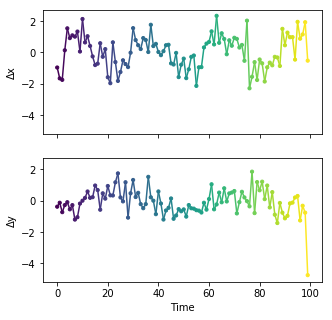

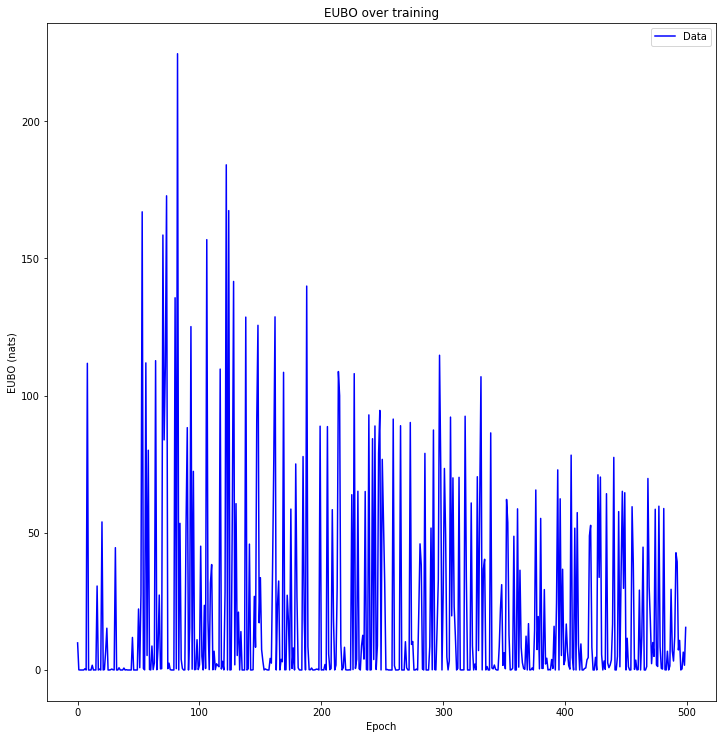

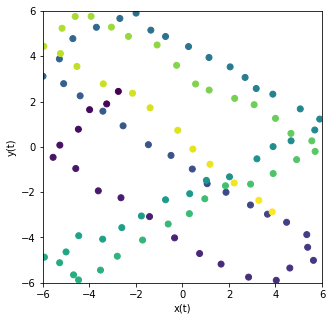

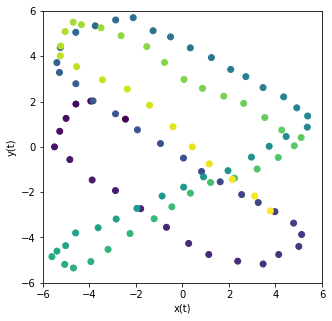

03/05/2019 12:44:29 MSE at time 0: tensor(1.5968)
03/05/2019 12:44:29 MSE at time 1: tensor(0.4822)
03/05/2019 12:44:29 MSE at time 2: tensor(0.4097)
03/05/2019 12:44:29 MSE at time 3: tensor(0.5090)
03/05/2019 12:44:29 MSE at time 4: tensor(0.3737)
03/05/2019 12:44:29 MSE at time 5: tensor(0.2161)
03/05/2019 12:44:29 MSE at time 6: tensor(0.2210)
03/05/2019 12:44:29 MSE at time 7: tensor(0.2996)
03/05/2019 12:44:29 MSE at time 8: tensor(0.1566)
03/05/2019 12:44:29 MSE at time 9: tensor(0.2664)
03/05/2019 12:44:29 MSE at time 10: tensor(0.3404)
03/05/2019 12:44:29 MSE at time 11: tensor(0.4186)
03/05/2019 12:44:29 MSE at time 12: tensor(0.4590)
03/05/2019 12:44:29 MSE at time 13: tensor(0.7155)
03/05/2019 12:44:29 MSE at time 14: tensor(0.8408)
03/05/2019 12:44:29 MSE at time 15: tensor(0.5855)
03/05/2019 12:44:29 MSE at time 16: tensor(0.7729)
03/05/2019 12:44:29 MSE at time 17: tensor(0.3852)
03/05/2019 12:44:29 MSE at time 18: tensor(0.5770)
03/05/2019 12:44:29 MSE at time 19: tenso

Epoch   111: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 12:44:50 EUBO=9.16503448e+01 at epoch 114
03/05/2019 12:44:50 EUBO=2.91266975e+01 at epoch 115
03/05/2019 12:44:51 EUBO=1.01688065e+02 at epoch 116
03/05/2019 12:44:51 EUBO=7.10937381e-01 at epoch 117
03/05/2019 12:44:51 EUBO=2.01496620e+01 at epoch 118
03/05/2019 12:44:51 EUBO=1.67778842e-02 at epoch 119
03/05/2019 12:44:51 EUBO=1.30031896e+00 at epoch 120
03/05/2019 12:44:52 EUBO=6.57197734e-06 at epoch 121
03/05/2019 12:44:52 EUBO=8.31086731e+01 at epoch 122
03/05/2019 12:44:52 EUBO=2.53671417e+01 at epoch 123
03/05/2019 12:44:52 EUBO=1.24076714e+02 at epoch 124
03/05/2019 12:44:52 EUBO=4.84287033e+01 at epoch 125
03/05/2019 12:44:52 EUBO=2.93959904e+01 at epoch 126
03/05/2019 12:44:53 EUBO=1.94731197e+01 at epoch 127
03/05/2019 12:44:53 EUBO=4.19786110e+01 at epoch 128
03/05/2019 12:44:53 EUBO=1.02193588e+02 at epoch 129
03/05/2019 12:44:53 EUBO=4.18675690e+01 at epoch 130
03/05/2019 12:44:53 EUBO=3.44604142e-02 at epoch 131
03/05/2019 12:44:54 EUBO=7.34805603e+01 at epo

Epoch   212: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 12:45:09 EUBO=1.17256820e-01 at epoch 215
03/05/2019 12:45:09 EUBO=4.27584267e+01 at epoch 216
03/05/2019 12:45:09 EUBO=2.53621023e-02 at epoch 217
03/05/2019 12:45:09 EUBO=4.04503393e+00 at epoch 218
03/05/2019 12:45:10 EUBO=1.40355770e-02 at epoch 219
03/05/2019 12:45:10 EUBO=1.20431614e+00 at epoch 220
03/05/2019 12:45:10 EUBO=8.24446857e-01 at epoch 221
03/05/2019 12:45:10 EUBO=1.01688597e-02 at epoch 222
03/05/2019 12:45:10 EUBO=7.90748894e-01 at epoch 223
03/05/2019 12:45:11 EUBO=7.93713450e-01 at epoch 224
03/05/2019 12:45:11 EUBO=2.64131851e+01 at epoch 225
03/05/2019 12:45:11 EUBO=3.83032799e+01 at epoch 226
03/05/2019 12:45:11 EUBO=1.82042751e+01 at epoch 227
03/05/2019 12:45:11 EUBO=8.98663342e-01 at epoch 228
03/05/2019 12:45:12 EUBO=2.43650513e+01 at epoch 229
03/05/2019 12:45:12 EUBO=2.71861199e-02 at epoch 230
03/05/2019 12:45:12 EUBO=9.23454687e-02 at epoch 231
03/05/2019 12:45:12 EUBO=2.42520552e-02 at epoch 232
03/05/2019 12:45:12 EUBO=9.52640629e+00 at epo

Epoch   313: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 12:45:27 EUBO=4.38730087e+01 at epoch 316
03/05/2019 12:45:28 EUBO=1.31084883e+00 at epoch 317
03/05/2019 12:45:28 EUBO=1.36400431e-01 at epoch 318
03/05/2019 12:45:28 EUBO=3.20091748e+00 at epoch 319
03/05/2019 12:45:28 EUBO=3.13118029e+00 at epoch 320
03/05/2019 12:45:28 EUBO=2.80033855e+01 at epoch 321
03/05/2019 12:45:28 EUBO=3.25431153e-02 at epoch 322
03/05/2019 12:45:28 EUBO=7.86859512e+01 at epoch 323
03/05/2019 12:45:29 EUBO=1.62705425e-02 at epoch 324
03/05/2019 12:45:29 EUBO=6.48254929e+01 at epoch 325
03/05/2019 12:45:29 EUBO=1.44759822e+00 at epoch 326
03/05/2019 12:45:29 EUBO=1.20547569e+00 at epoch 327
03/05/2019 12:45:29 EUBO=4.73139191e+00 at epoch 328
03/05/2019 12:45:29 EUBO=2.95472031e+01 at epoch 329
03/05/2019 12:45:30 EUBO=4.36563301e+00 at epoch 330
03/05/2019 12:45:30 EUBO=2.43163452e+01 at epoch 331
03/05/2019 12:45:30 EUBO=1.25103327e-03 at epoch 332
03/05/2019 12:45:30 EUBO=1.62050056e+01 at epoch 333
03/05/2019 12:45:30 EUBO=3.83053970e+01 at epo

Epoch   414: reducing learning rate of group 0 to 6.2500e-03.


03/05/2019 12:45:45 EUBO=5.20039330e+01 at epoch 417
03/05/2019 12:45:45 EUBO=2.43736839e+00 at epoch 418
03/05/2019 12:45:46 EUBO=3.70452156e+01 at epoch 419
03/05/2019 12:45:46 EUBO=6.87540472e-02 at epoch 420
03/05/2019 12:45:46 EUBO=1.45948052e+00 at epoch 421
03/05/2019 12:45:46 EUBO=4.40466499e+01 at epoch 422
03/05/2019 12:45:46 EUBO=6.90015697e+00 at epoch 423
03/05/2019 12:45:46 EUBO=2.85211277e+00 at epoch 424
03/05/2019 12:45:47 EUBO=4.39623985e+01 at epoch 425
03/05/2019 12:45:47 EUBO=6.52656257e-02 at epoch 426
03/05/2019 12:45:47 EUBO=2.39871576e-01 at epoch 427
03/05/2019 12:45:47 EUBO=5.04466896e+01 at epoch 428
03/05/2019 12:45:47 EUBO=2.10665545e-04 at epoch 429
03/05/2019 12:45:48 EUBO=1.11010516e+00 at epoch 430
03/05/2019 12:45:48 EUBO=8.30897316e-02 at epoch 431
03/05/2019 12:45:48 EUBO=3.71371613e+01 at epoch 432
03/05/2019 12:45:48 EUBO=2.75368309e+01 at epoch 433
03/05/2019 12:45:48 EUBO=7.44799185e+00 at epoch 434
03/05/2019 12:45:48 EUBO=1.08940446e+00 at epo

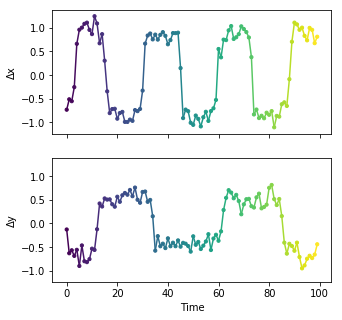

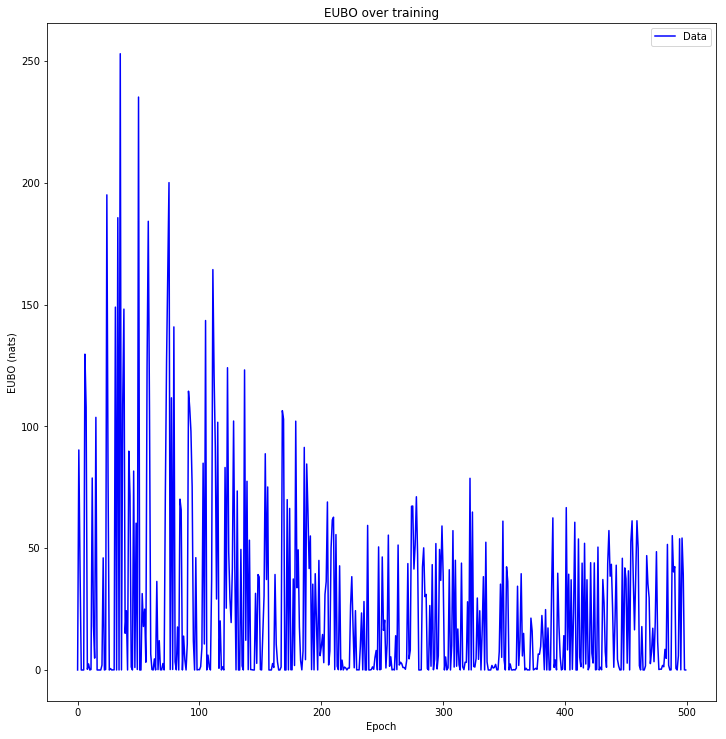

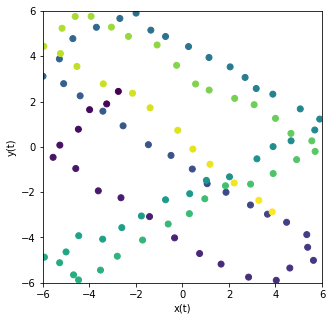

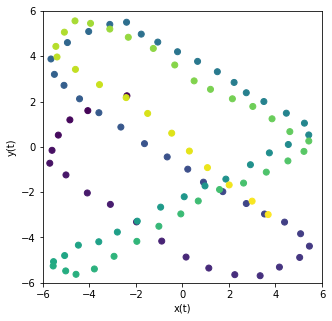

03/05/2019 12:46:01 MSE at time 0: tensor(0.1731)
03/05/2019 12:46:01 MSE at time 1: tensor(0.7465)
03/05/2019 12:46:01 MSE at time 2: tensor(0.9220)
03/05/2019 12:46:01 MSE at time 3: tensor(0.8119)
03/05/2019 12:46:01 MSE at time 4: tensor(0.1651)
03/05/2019 12:46:01 MSE at time 5: tensor(0.0884)
03/05/2019 12:46:01 MSE at time 6: tensor(0.2581)
03/05/2019 12:46:01 MSE at time 7: tensor(0.2323)
03/05/2019 12:46:01 MSE at time 8: tensor(0.2938)
03/05/2019 12:46:01 MSE at time 9: tensor(0.3685)
03/05/2019 12:46:01 MSE at time 10: tensor(0.3260)
03/05/2019 12:46:01 MSE at time 11: tensor(0.3634)
03/05/2019 12:46:01 MSE at time 12: tensor(0.3091)
03/05/2019 12:46:01 MSE at time 13: tensor(0.3638)
03/05/2019 12:46:01 MSE at time 14: tensor(0.5219)
03/05/2019 12:46:01 MSE at time 15: tensor(0.2018)
03/05/2019 12:46:01 MSE at time 16: tensor(0.3670)
03/05/2019 12:46:01 MSE at time 17: tensor(0.0082)
03/05/2019 12:46:01 MSE at time 18: tensor(0.0723)
03/05/2019 12:46:01 MSE at time 19: tenso

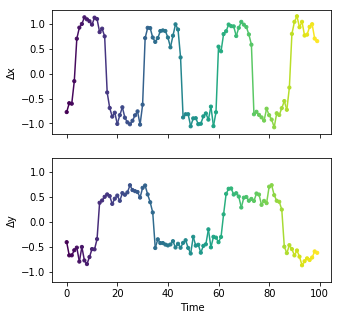

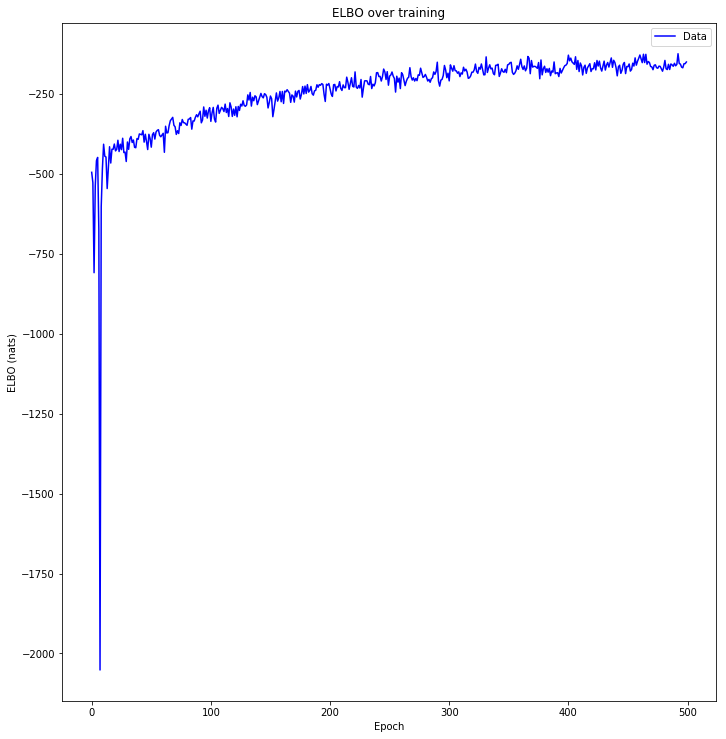

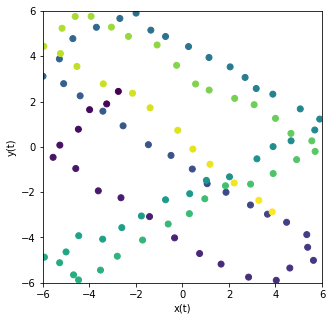

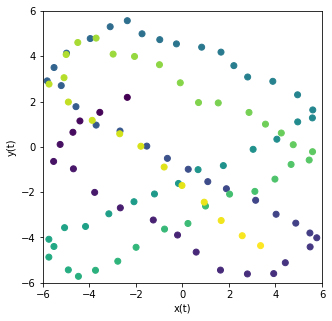

03/05/2019 12:47:21 MSE at time 0: tensor(0.2172)
03/05/2019 12:47:21 MSE at time 1: tensor(0.2261)
03/05/2019 12:47:21 MSE at time 2: tensor(0.4208)
03/05/2019 12:47:21 MSE at time 3: tensor(0.0733)
03/05/2019 12:47:21 MSE at time 4: tensor(0.0011)
03/05/2019 12:47:21 MSE at time 5: tensor(0.0336)
03/05/2019 12:47:21 MSE at time 6: tensor(0.0105)
03/05/2019 12:47:21 MSE at time 7: tensor(0.0292)
03/05/2019 12:47:21 MSE at time 8: tensor(0.2000)
03/05/2019 12:47:21 MSE at time 9: tensor(0.0487)
03/05/2019 12:47:21 MSE at time 10: tensor(0.0319)
03/05/2019 12:47:21 MSE at time 11: tensor(0.0255)
03/05/2019 12:47:21 MSE at time 12: tensor(0.0711)
03/05/2019 12:47:21 MSE at time 13: tensor(0.0224)
03/05/2019 12:47:21 MSE at time 14: tensor(0.1002)
03/05/2019 12:47:21 MSE at time 15: tensor(0.0924)
03/05/2019 12:47:21 MSE at time 16: tensor(0.3731)
03/05/2019 12:47:21 MSE at time 17: tensor(0.3296)
03/05/2019 12:47:21 MSE at time 18: tensor(0.0232)
03/05/2019 12:47:21 MSE at time 19: tenso

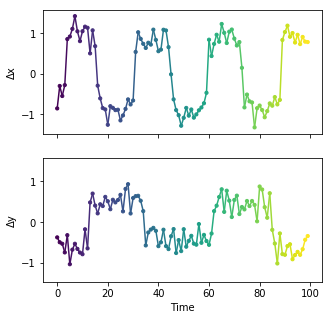

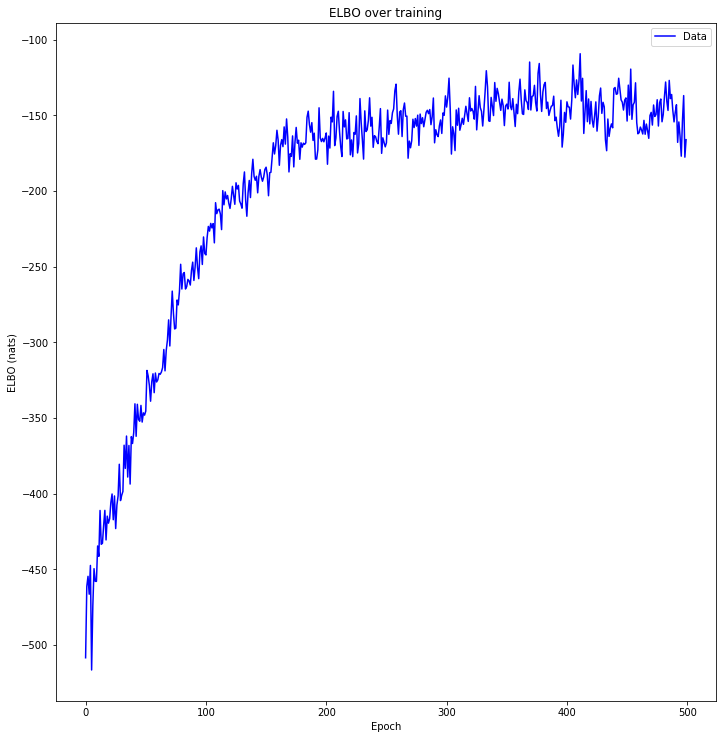

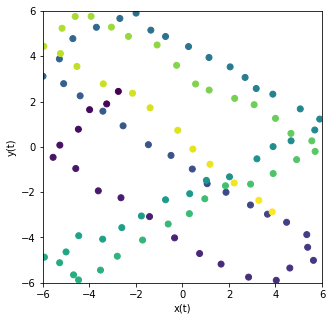

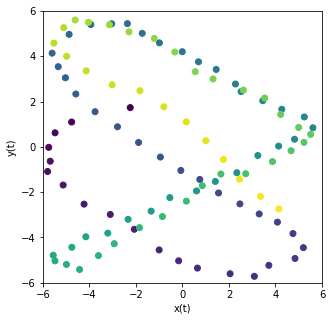

03/05/2019 12:48:43 MSE at time 0: tensor(0.7741)
03/05/2019 12:48:43 MSE at time 1: tensor(2.9138)
03/05/2019 12:48:43 MSE at time 2: tensor(3.2507)
03/05/2019 12:48:43 MSE at time 3: tensor(2.2659)
03/05/2019 12:48:43 MSE at time 4: tensor(0.6756)
03/05/2019 12:48:43 MSE at time 5: tensor(0.4464)
03/05/2019 12:48:43 MSE at time 6: tensor(0.8254)
03/05/2019 12:48:43 MSE at time 7: tensor(0.7217)
03/05/2019 12:48:43 MSE at time 8: tensor(0.7586)
03/05/2019 12:48:43 MSE at time 9: tensor(0.7433)
03/05/2019 12:48:43 MSE at time 10: tensor(0.7248)
03/05/2019 12:48:43 MSE at time 11: tensor(0.9132)
03/05/2019 12:48:43 MSE at time 12: tensor(1.0636)
03/05/2019 12:48:43 MSE at time 13: tensor(0.6559)
03/05/2019 12:48:43 MSE at time 14: tensor(0.9215)
03/05/2019 12:48:43 MSE at time 15: tensor(0.8276)
03/05/2019 12:48:43 MSE at time 16: tensor(0.6352)
03/05/2019 12:48:43 MSE at time 17: tensor(0.0341)
03/05/2019 12:48:43 MSE at time 18: tensor(0.3546)
03/05/2019 12:48:43 MSE at time 19: tenso

Epoch   492: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 12:50:13 ELBO=-1.31674271e+02 at epoch 495
03/05/2019 12:50:13 ELBO=-1.28887634e+02 at epoch 496
03/05/2019 12:50:13 ELBO=-1.29500854e+02 at epoch 497
03/05/2019 12:50:14 ELBO=-1.34550232e+02 at epoch 498
03/05/2019 12:50:14 ELBO=-1.30555542e+02 at epoch 499
03/05/2019 12:50:14 ELBO=-1.20206413e+02 at epoch 500


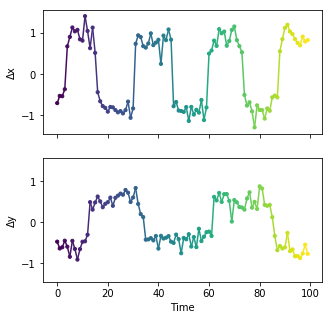

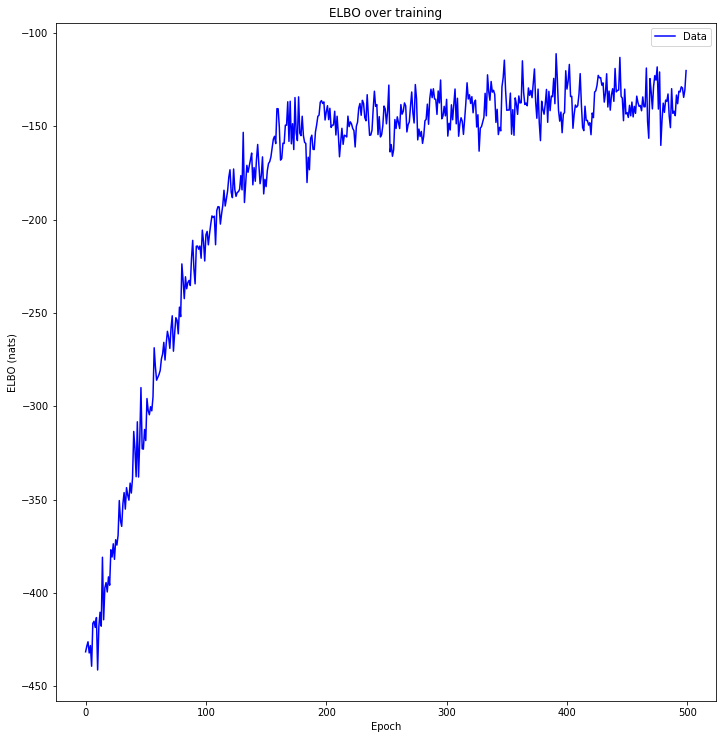

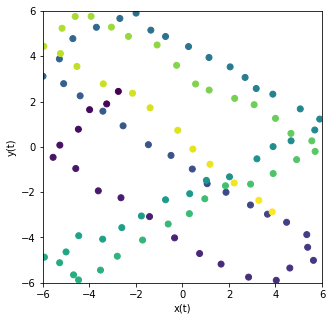

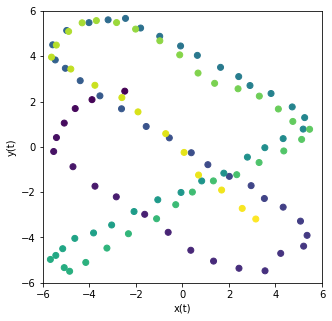

03/05/2019 12:50:14 MSE at time 0: tensor(0.0760)
03/05/2019 12:50:14 MSE at time 1: tensor(0.4333)
03/05/2019 12:50:14 MSE at time 2: tensor(0.3854)
03/05/2019 12:50:14 MSE at time 3: tensor(0.4421)
03/05/2019 12:50:14 MSE at time 4: tensor(0.1334)
03/05/2019 12:50:14 MSE at time 5: tensor(0.0667)
03/05/2019 12:50:14 MSE at time 6: tensor(0.0209)
03/05/2019 12:50:14 MSE at time 7: tensor(0.0621)
03/05/2019 12:50:14 MSE at time 8: tensor(0.0420)
03/05/2019 12:50:14 MSE at time 9: tensor(0.0534)
03/05/2019 12:50:14 MSE at time 10: tensor(0.1361)
03/05/2019 12:50:14 MSE at time 11: tensor(0.1637)
03/05/2019 12:50:14 MSE at time 12: tensor(0.1221)
03/05/2019 12:50:14 MSE at time 13: tensor(0.3236)
03/05/2019 12:50:14 MSE at time 14: tensor(0.4092)
03/05/2019 12:50:14 MSE at time 15: tensor(0.5710)
03/05/2019 12:50:14 MSE at time 16: tensor(0.5705)
03/05/2019 12:50:14 MSE at time 17: tensor(0.2781)
03/05/2019 12:50:14 MSE at time 18: tensor(0.4265)
03/05/2019 12:50:14 MSE at time 19: tenso

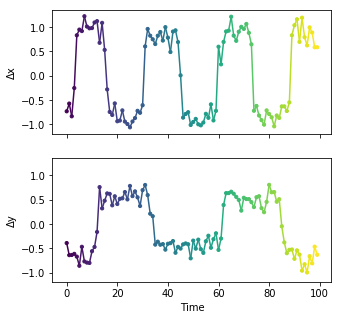

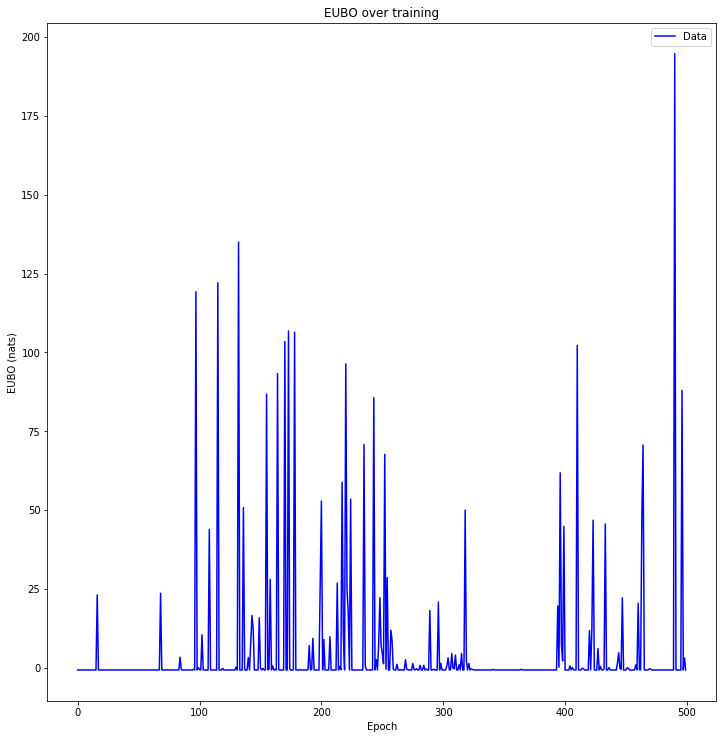

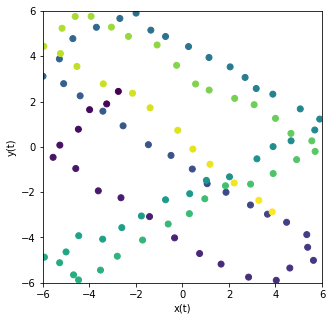

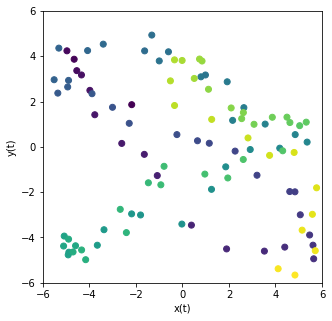

03/05/2019 12:51:37 MSE at time 0: tensor(0.6741)
03/05/2019 12:51:37 MSE at time 1: tensor(5.8464)
03/05/2019 12:51:37 MSE at time 2: tensor(7.7054)
03/05/2019 12:51:37 MSE at time 3: tensor(6.6917)
03/05/2019 12:51:37 MSE at time 4: tensor(10.4636)
03/05/2019 12:51:37 MSE at time 5: tensor(11.2405)
03/05/2019 12:51:37 MSE at time 6: tensor(6.3051)
03/05/2019 12:51:37 MSE at time 7: tensor(5.3970)
03/05/2019 12:51:37 MSE at time 8: tensor(4.6753)
03/05/2019 12:51:37 MSE at time 9: tensor(3.3905)
03/05/2019 12:51:37 MSE at time 10: tensor(0.8405)
03/05/2019 12:51:37 MSE at time 11: tensor(1.3890)
03/05/2019 12:51:37 MSE at time 12: tensor(3.7997)
03/05/2019 12:51:37 MSE at time 13: tensor(4.1769)
03/05/2019 12:51:37 MSE at time 14: tensor(3.4920)
03/05/2019 12:51:37 MSE at time 15: tensor(2.0104)
03/05/2019 12:51:37 MSE at time 16: tensor(1.2795)
03/05/2019 12:51:37 MSE at time 17: tensor(2.1574)
03/05/2019 12:51:37 MSE at time 18: tensor(3.8277)
03/05/2019 12:51:37 MSE at time 19: ten

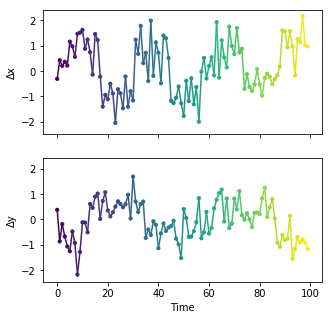

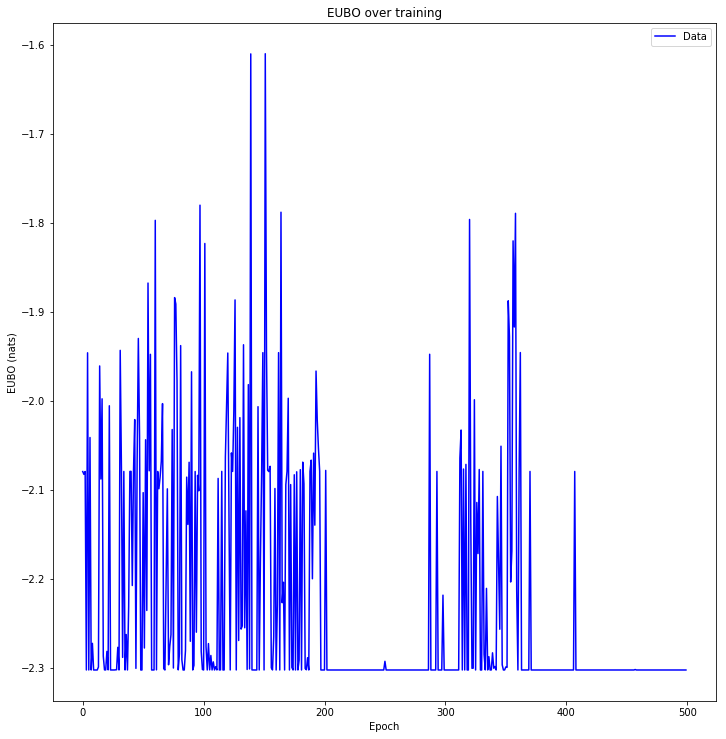

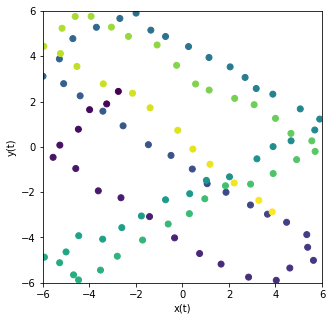

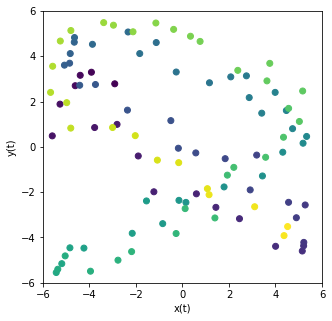

03/05/2019 12:52:55 MSE at time 0: tensor(0.1364)
03/05/2019 12:52:55 MSE at time 1: tensor(2.3873)
03/05/2019 12:52:55 MSE at time 2: tensor(2.4667)
03/05/2019 12:52:55 MSE at time 3: tensor(3.7094)
03/05/2019 12:52:55 MSE at time 4: tensor(3.2742)
03/05/2019 12:52:55 MSE at time 5: tensor(0.8976)
03/05/2019 12:52:55 MSE at time 6: tensor(3.9286)
03/05/2019 12:52:55 MSE at time 7: tensor(9.2544)
03/05/2019 12:52:55 MSE at time 8: tensor(3.9503)
03/05/2019 12:52:55 MSE at time 9: tensor(1.2353)
03/05/2019 12:52:55 MSE at time 10: tensor(4.6592)
03/05/2019 12:52:55 MSE at time 11: tensor(4.6491)
03/05/2019 12:52:55 MSE at time 12: tensor(4.6445)
03/05/2019 12:52:55 MSE at time 13: tensor(3.2012)
03/05/2019 12:52:55 MSE at time 14: tensor(2.9242)
03/05/2019 12:52:55 MSE at time 15: tensor(1.3147)
03/05/2019 12:52:55 MSE at time 16: tensor(0.8002)
03/05/2019 12:52:55 MSE at time 17: tensor(3.5005)
03/05/2019 12:52:55 MSE at time 18: tensor(0.7560)
03/05/2019 12:52:55 MSE at time 19: tenso

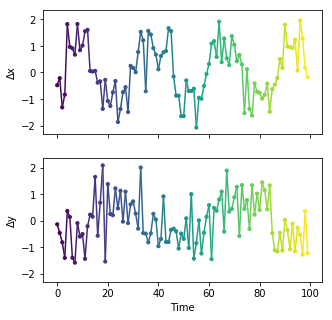

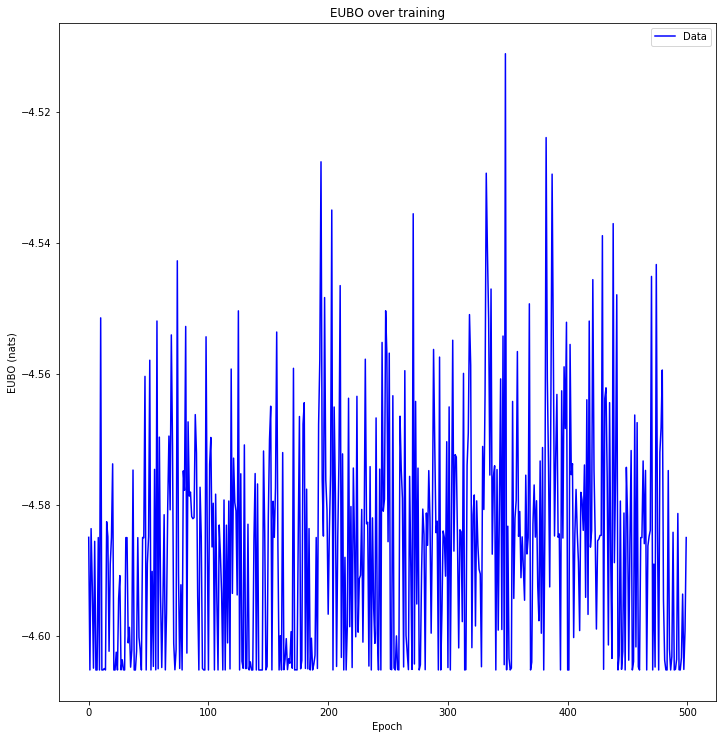

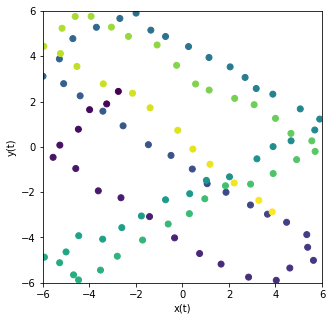

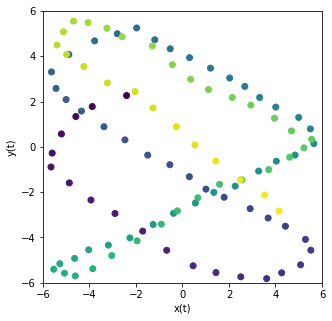

03/05/2019 12:54:21 MSE at time 0: tensor(0.1595)
03/05/2019 12:54:21 MSE at time 1: tensor(0.3985)
03/05/2019 12:54:21 MSE at time 2: tensor(0.4407)
03/05/2019 12:54:21 MSE at time 3: tensor(0.5748)
03/05/2019 12:54:21 MSE at time 4: tensor(0.2305)
03/05/2019 12:54:21 MSE at time 5: tensor(0.1913)
03/05/2019 12:54:21 MSE at time 6: tensor(0.4808)
03/05/2019 12:54:21 MSE at time 7: tensor(0.2657)
03/05/2019 12:54:21 MSE at time 8: tensor(0.5496)
03/05/2019 12:54:21 MSE at time 9: tensor(0.4978)
03/05/2019 12:54:21 MSE at time 10: tensor(0.4152)
03/05/2019 12:54:21 MSE at time 11: tensor(0.3706)
03/05/2019 12:54:21 MSE at time 12: tensor(0.1891)
03/05/2019 12:54:21 MSE at time 13: tensor(0.1135)
03/05/2019 12:54:21 MSE at time 14: tensor(0.1757)
03/05/2019 12:54:21 MSE at time 15: tensor(0.1678)
03/05/2019 12:54:21 MSE at time 16: tensor(0.3449)
03/05/2019 12:54:21 MSE at time 17: tensor(0.0351)
03/05/2019 12:54:21 MSE at time 18: tensor(0.0478)
03/05/2019 12:54:21 MSE at time 19: tenso

Epoch   390: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 12:55:45 ELBO=-6.18957825e+02 at epoch 393
03/05/2019 12:55:45 ELBO=-6.31798645e+02 at epoch 394
03/05/2019 12:55:46 ELBO=-6.31521973e+02 at epoch 395
03/05/2019 12:55:46 ELBO=-6.41979309e+02 at epoch 396
03/05/2019 12:55:46 ELBO=-6.39403931e+02 at epoch 397
03/05/2019 12:55:46 ELBO=-6.31504883e+02 at epoch 398
03/05/2019 12:55:46 ELBO=-6.19496826e+02 at epoch 399
03/05/2019 12:55:47 ELBO=-6.30031555e+02 at epoch 400
03/05/2019 12:55:47 ELBO=-6.34590515e+02 at epoch 401
03/05/2019 12:55:47 ELBO=-6.36538696e+02 at epoch 402
03/05/2019 12:55:47 ELBO=-6.49746094e+02 at epoch 403
03/05/2019 12:55:48 ELBO=-6.45908569e+02 at epoch 404
03/05/2019 12:55:48 ELBO=-6.28467224e+02 at epoch 405
03/05/2019 12:55:48 ELBO=-6.15170532e+02 at epoch 406
03/05/2019 12:55:48 ELBO=-6.20344360e+02 at epoch 407
03/05/2019 12:55:48 ELBO=-6.39546631e+02 at epoch 408
03/05/2019 12:55:49 ELBO=-6.41586670e+02 at epoch 409
03/05/2019 12:55:49 ELBO=-6.34012451e+02 at epoch 410
03/05/2019 12:55:49 ELBO=-6.

Epoch   491: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 12:56:07 ELBO=-6.58280090e+02 at epoch 494
03/05/2019 12:56:07 ELBO=-6.38027588e+02 at epoch 495
03/05/2019 12:56:07 ELBO=-6.32363831e+02 at epoch 496
03/05/2019 12:56:07 ELBO=-6.40980103e+02 at epoch 497
03/05/2019 12:56:08 ELBO=-6.35388306e+02 at epoch 498
03/05/2019 12:56:08 ELBO=-6.32638916e+02 at epoch 499
03/05/2019 12:56:08 ELBO=-6.17500977e+02 at epoch 500


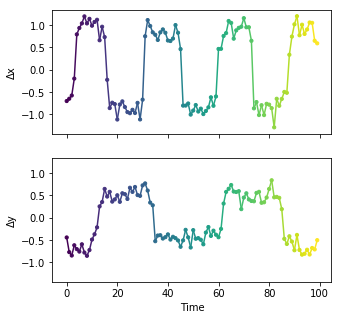

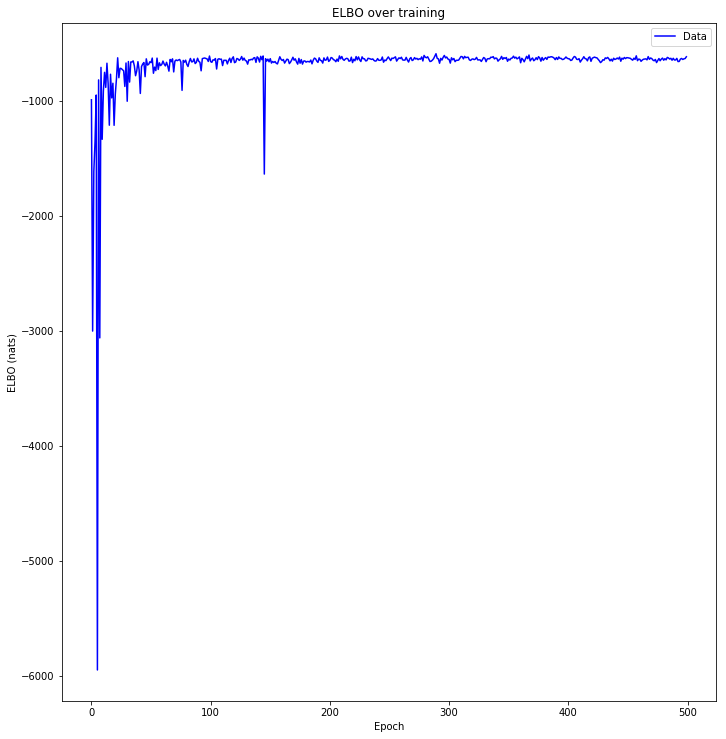

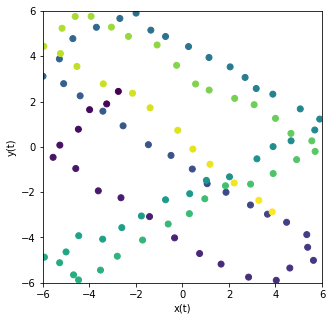

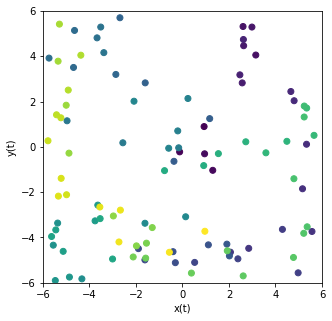

03/05/2019 12:56:09 MSE at time 0: tensor(16.0115)
03/05/2019 12:56:09 MSE at time 1: tensor(14.3300)
03/05/2019 12:56:09 MSE at time 2: tensor(35.2258)
03/05/2019 12:56:09 MSE at time 3: tensor(30.6522)
03/05/2019 12:56:09 MSE at time 4: tensor(86.8484)
03/05/2019 12:56:09 MSE at time 5: tensor(100.0856)
03/05/2019 12:56:09 MSE at time 6: tensor(96.4107)
03/05/2019 12:56:09 MSE at time 7: tensor(80.1166)
03/05/2019 12:56:09 MSE at time 8: tensor(52.9009)
03/05/2019 12:56:09 MSE at time 9: tensor(54.2678)
03/05/2019 12:56:09 MSE at time 10: tensor(85.4552)
03/05/2019 12:56:09 MSE at time 11: tensor(66.5783)
03/05/2019 12:56:09 MSE at time 12: tensor(61.8951)
03/05/2019 12:56:09 MSE at time 13: tensor(40.6302)
03/05/2019 12:56:09 MSE at time 14: tensor(17.6077)
03/05/2019 12:56:09 MSE at time 15: tensor(3.5118)
03/05/2019 12:56:09 MSE at time 16: tensor(8.0284)
03/05/2019 12:56:09 MSE at time 17: tensor(11.0769)
03/05/2019 12:56:09 MSE at time 18: tensor(1.1511)
03/05/2019 12:56:09 MSE 

Epoch   306: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 12:57:16 ELBO=-2.86659729e+02 at epoch 309
03/05/2019 12:57:16 ELBO=-2.59027344e+02 at epoch 310
03/05/2019 12:57:16 ELBO=-2.34711594e+02 at epoch 311
03/05/2019 12:57:16 ELBO=-2.62027283e+02 at epoch 312
03/05/2019 12:57:17 ELBO=-2.78505859e+02 at epoch 313
03/05/2019 12:57:17 ELBO=-2.52228973e+02 at epoch 314
03/05/2019 12:57:17 ELBO=-2.42313080e+02 at epoch 315
03/05/2019 12:57:17 ELBO=-2.68155579e+02 at epoch 316
03/05/2019 12:57:18 ELBO=-2.94349579e+02 at epoch 317
03/05/2019 12:57:18 ELBO=-2.61220490e+02 at epoch 318
03/05/2019 12:57:18 ELBO=-2.45330109e+02 at epoch 319
03/05/2019 12:57:18 ELBO=-2.55303192e+02 at epoch 320
03/05/2019 12:57:18 ELBO=-2.73269745e+02 at epoch 321
03/05/2019 12:57:19 ELBO=-2.37645538e+02 at epoch 322
03/05/2019 12:57:19 ELBO=-2.65904114e+02 at epoch 323
03/05/2019 12:57:19 ELBO=-2.13200287e+02 at epoch 324
03/05/2019 12:57:19 ELBO=-2.78376038e+02 at epoch 325
03/05/2019 12:57:20 ELBO=-2.72160919e+02 at epoch 326
03/05/2019 12:57:20 ELBO=-2.

Epoch   453: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 12:57:48 ELBO=-2.67250031e+02 at epoch 456
03/05/2019 12:57:49 ELBO=-2.33859100e+02 at epoch 457
03/05/2019 12:57:49 ELBO=-2.02112045e+02 at epoch 458
03/05/2019 12:57:49 ELBO=-2.50174408e+02 at epoch 459
03/05/2019 12:57:49 ELBO=-2.07018433e+02 at epoch 460
03/05/2019 12:57:50 ELBO=-2.53677765e+02 at epoch 461
03/05/2019 12:57:50 ELBO=-2.34318756e+02 at epoch 462
03/05/2019 12:57:50 ELBO=-2.55184982e+02 at epoch 463
03/05/2019 12:57:50 ELBO=-2.57860413e+02 at epoch 464
03/05/2019 12:57:50 ELBO=-2.49407227e+02 at epoch 465
03/05/2019 12:57:51 ELBO=-2.37978119e+02 at epoch 466
03/05/2019 12:57:51 ELBO=-2.44689178e+02 at epoch 467
03/05/2019 12:57:51 ELBO=-2.19991730e+02 at epoch 468
03/05/2019 12:57:51 ELBO=-2.42373322e+02 at epoch 469
03/05/2019 12:57:52 ELBO=-2.54376709e+02 at epoch 470
03/05/2019 12:57:52 ELBO=-2.31304962e+02 at epoch 471
03/05/2019 12:57:52 ELBO=-2.38408447e+02 at epoch 472
03/05/2019 12:57:52 ELBO=-2.17574432e+02 at epoch 473
03/05/2019 12:57:52 ELBO=-2.

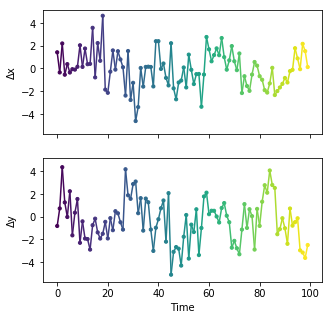

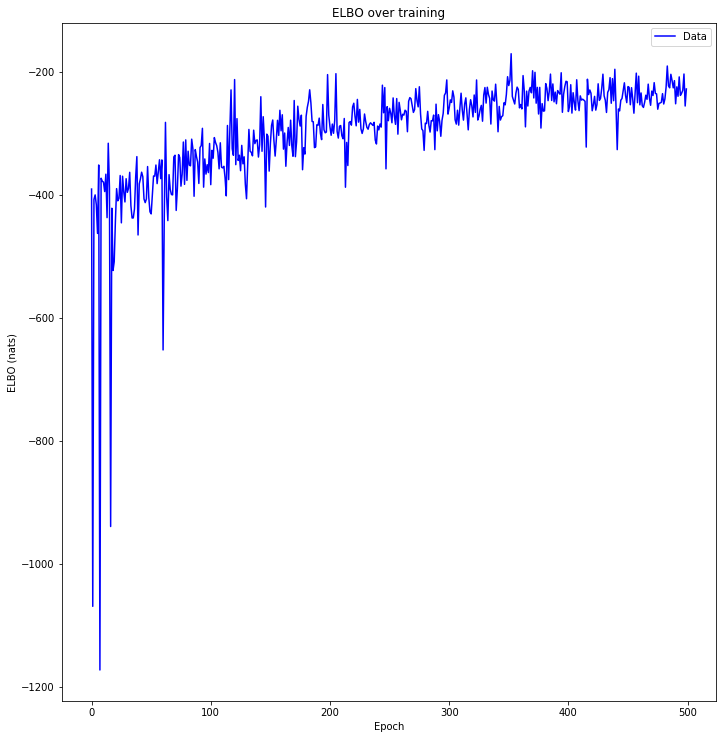

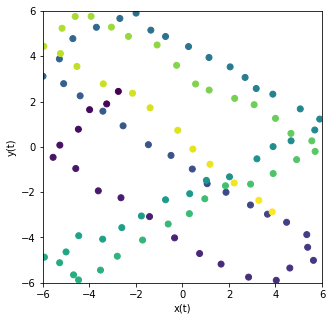

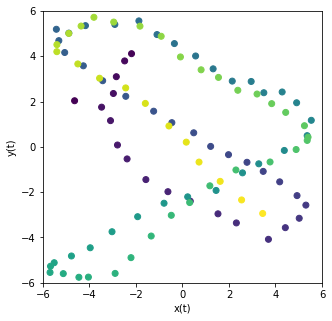

03/05/2019 12:57:58 MSE at time 0: tensor(3.7150)
03/05/2019 12:57:58 MSE at time 1: tensor(6.0617)
03/05/2019 12:57:58 MSE at time 2: tensor(6.9083)
03/05/2019 12:57:58 MSE at time 3: tensor(8.0415)
03/05/2019 12:57:58 MSE at time 4: tensor(10.5017)
03/05/2019 12:57:58 MSE at time 5: tensor(9.2534)
03/05/2019 12:57:58 MSE at time 6: tensor(6.7012)
03/05/2019 12:57:58 MSE at time 7: tensor(4.7692)
03/05/2019 12:57:58 MSE at time 8: tensor(3.0047)
03/05/2019 12:57:58 MSE at time 9: tensor(2.6943)
03/05/2019 12:57:58 MSE at time 10: tensor(4.2394)
03/05/2019 12:57:58 MSE at time 11: tensor(5.5063)
03/05/2019 12:57:58 MSE at time 12: tensor(4.9441)
03/05/2019 12:57:58 MSE at time 13: tensor(6.0017)
03/05/2019 12:57:58 MSE at time 14: tensor(3.3887)
03/05/2019 12:57:58 MSE at time 15: tensor(3.2105)
03/05/2019 12:57:58 MSE at time 16: tensor(3.8263)
03/05/2019 12:57:58 MSE at time 17: tensor(3.4702)
03/05/2019 12:57:58 MSE at time 18: tensor(3.1393)
03/05/2019 12:57:58 MSE at time 19: tens

Epoch   270: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 12:59:06 ELBO=-3.70777496e+02 at epoch 273
03/05/2019 12:59:06 ELBO=-3.45556091e+02 at epoch 274
03/05/2019 12:59:06 ELBO=-3.64282623e+02 at epoch 275
03/05/2019 12:59:07 ELBO=-3.60957642e+02 at epoch 276
03/05/2019 12:59:07 ELBO=-4.24777802e+02 at epoch 277
03/05/2019 12:59:07 ELBO=-4.02479065e+02 at epoch 278
03/05/2019 12:59:07 ELBO=-3.11367676e+02 at epoch 279
03/05/2019 12:59:08 ELBO=-3.15312531e+02 at epoch 280
03/05/2019 12:59:08 ELBO=-3.61669800e+02 at epoch 281
03/05/2019 12:59:08 ELBO=-1.84439758e+02 at epoch 282
03/05/2019 12:59:08 ELBO=-3.46979889e+02 at epoch 283
03/05/2019 12:59:09 ELBO=-4.57959564e+02 at epoch 284
03/05/2019 12:59:09 ELBO=-3.08504700e+02 at epoch 285
03/05/2019 12:59:09 ELBO=-2.90279480e+02 at epoch 286
03/05/2019 12:59:09 ELBO=-2.95124542e+02 at epoch 287
03/05/2019 12:59:10 ELBO=-3.11686829e+02 at epoch 288
03/05/2019 12:59:10 ELBO=-3.49505737e+02 at epoch 289
03/05/2019 12:59:10 ELBO=-5.94727783e+02 at epoch 290
03/05/2019 12:59:10 ELBO=-2.

Epoch   371: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 12:59:31 ELBO=-3.71011688e+02 at epoch 374
03/05/2019 12:59:31 ELBO=-4.96874603e+02 at epoch 375
03/05/2019 12:59:31 ELBO=-1.45307632e+02 at epoch 376
03/05/2019 12:59:32 ELBO=-2.98278503e+02 at epoch 377
03/05/2019 12:59:32 ELBO=-2.59143951e+02 at epoch 378
03/05/2019 12:59:32 ELBO=-1.27517273e+02 at epoch 379
03/05/2019 12:59:32 ELBO=-3.80384491e+02 at epoch 380
03/05/2019 12:59:33 ELBO=-4.27471436e+02 at epoch 381
03/05/2019 12:59:33 ELBO=-4.81265747e+02 at epoch 382
03/05/2019 12:59:33 ELBO=-4.57376129e+02 at epoch 383
03/05/2019 12:59:33 ELBO=-2.85938843e+02 at epoch 384
03/05/2019 12:59:34 ELBO=-3.45322510e+02 at epoch 385
03/05/2019 12:59:34 ELBO=-4.82269562e+02 at epoch 386
03/05/2019 12:59:34 ELBO=-3.91607239e+02 at epoch 387
03/05/2019 12:59:34 ELBO=-3.87197937e+02 at epoch 388
03/05/2019 12:59:35 ELBO=-3.65613983e+02 at epoch 389
03/05/2019 12:59:35 ELBO=-3.38358154e+02 at epoch 390
03/05/2019 12:59:35 ELBO=-3.40916565e+02 at epoch 391
03/05/2019 12:59:35 ELBO=-4.

Epoch   472: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 12:59:56 ELBO=-3.11919891e+02 at epoch 474
03/05/2019 12:59:56 ELBO=-3.04306763e+02 at epoch 475
03/05/2019 12:59:57 ELBO=-2.82599426e+02 at epoch 476
03/05/2019 12:59:57 ELBO=-3.76374176e+02 at epoch 477
03/05/2019 12:59:57 ELBO=-2.00142166e+02 at epoch 478
03/05/2019 12:59:58 ELBO=-2.74557434e+02 at epoch 479
03/05/2019 12:59:58 ELBO=-4.23004303e+02 at epoch 480
03/05/2019 12:59:58 ELBO=-2.51687546e+02 at epoch 481
03/05/2019 12:59:58 ELBO=-4.01072266e+02 at epoch 482
03/05/2019 12:59:59 ELBO=-2.13834625e+02 at epoch 483
03/05/2019 12:59:59 ELBO=-4.04589142e+02 at epoch 484
03/05/2019 12:59:59 ELBO=-3.43627136e+02 at epoch 485
03/05/2019 12:59:59 ELBO=-3.63146576e+02 at epoch 486
03/05/2019 13:00:00 ELBO=-3.33137512e+02 at epoch 487
03/05/2019 13:00:00 ELBO=-3.66796722e+02 at epoch 488
03/05/2019 13:00:00 ELBO=-2.03512283e+02 at epoch 489
03/05/2019 13:00:01 ELBO=-3.08553894e+02 at epoch 490
03/05/2019 13:00:01 ELBO=-1.96424469e+02 at epoch 491
03/05/2019 13:00:01 ELBO=-2.

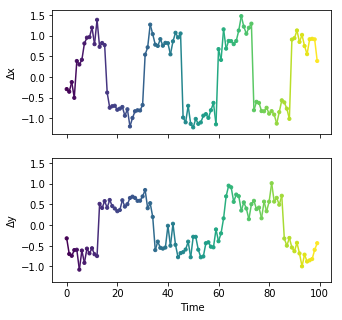

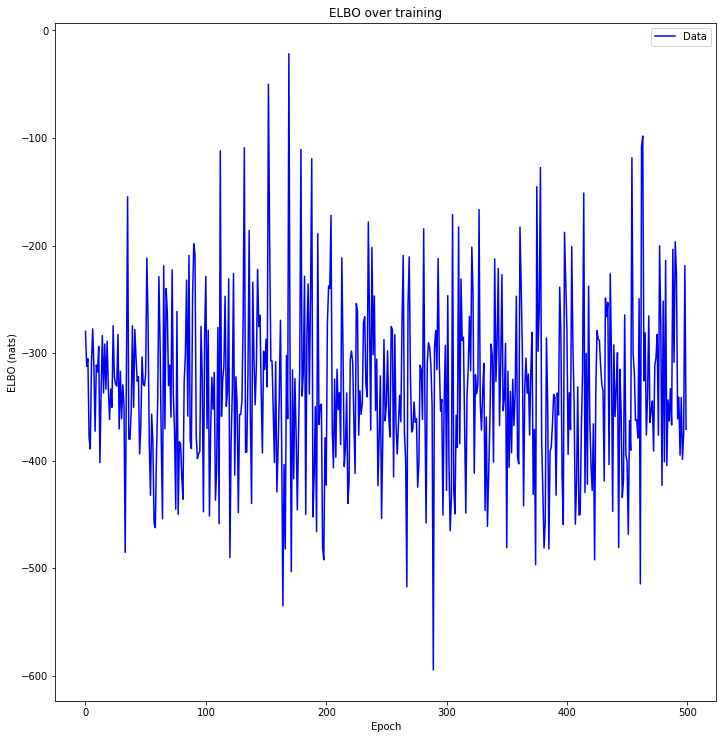

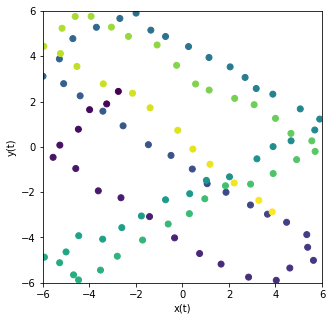

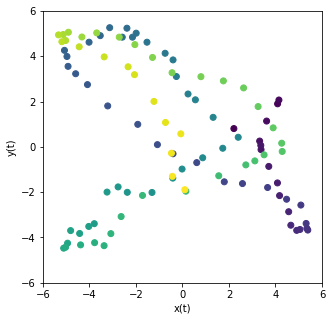

03/05/2019 13:00:04 MSE at time 0: tensor(27.3830)
03/05/2019 13:00:04 MSE at time 1: tensor(54.0323)
03/05/2019 13:00:04 MSE at time 2: tensor(66.4869)
03/05/2019 13:00:04 MSE at time 3: tensor(65.6789)
03/05/2019 13:00:04 MSE at time 4: tensor(73.9001)
03/05/2019 13:00:04 MSE at time 5: tensor(80.1087)
03/05/2019 13:00:04 MSE at time 6: tensor(64.3730)
03/05/2019 13:00:04 MSE at time 7: tensor(54.9199)
03/05/2019 13:00:04 MSE at time 8: tensor(45.7276)
03/05/2019 13:00:04 MSE at time 9: tensor(32.1365)
03/05/2019 13:00:04 MSE at time 10: tensor(25.4199)
03/05/2019 13:00:04 MSE at time 11: tensor(16.9600)
03/05/2019 13:00:04 MSE at time 12: tensor(12.7976)
03/05/2019 13:00:04 MSE at time 13: tensor(9.3110)
03/05/2019 13:00:04 MSE at time 14: tensor(6.7576)
03/05/2019 13:00:04 MSE at time 15: tensor(3.6031)
03/05/2019 13:00:04 MSE at time 16: tensor(2.7524)
03/05/2019 13:00:04 MSE at time 17: tensor(3.5575)
03/05/2019 13:00:04 MSE at time 18: tensor(3.1924)
03/05/2019 13:00:04 MSE at t

Epoch   205: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 13:00:49 EUBO=3.17343262e+02 at epoch 208
03/05/2019 13:00:49 EUBO=5.45315491e+02 at epoch 209
03/05/2019 13:00:50 EUBO=3.25563904e+02 at epoch 210
03/05/2019 13:00:50 EUBO=3.14803589e+02 at epoch 211
03/05/2019 13:00:50 EUBO=3.10850586e+02 at epoch 212
03/05/2019 13:00:50 EUBO=3.44428650e+02 at epoch 213
03/05/2019 13:00:50 EUBO=3.55018677e+02 at epoch 214
03/05/2019 13:00:51 EUBO=3.14488647e+02 at epoch 215
03/05/2019 13:00:51 EUBO=3.37315430e+02 at epoch 216
03/05/2019 13:00:51 EUBO=3.28964355e+02 at epoch 217
03/05/2019 13:00:51 EUBO=3.39613129e+02 at epoch 218
03/05/2019 13:00:51 EUBO=3.15560944e+02 at epoch 219
03/05/2019 13:00:51 EUBO=3.18729950e+02 at epoch 220
03/05/2019 13:00:52 EUBO=3.46387451e+02 at epoch 221
03/05/2019 13:00:52 EUBO=3.27781311e+02 at epoch 222
03/05/2019 13:00:52 EUBO=3.20819916e+02 at epoch 223
03/05/2019 13:00:52 EUBO=3.45188599e+02 at epoch 224
03/05/2019 13:00:52 EUBO=3.15948639e+02 at epoch 225
03/05/2019 13:00:53 EUBO=4.74428009e+02 at epo

Epoch   416: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 13:01:30 EUBO=3.21600311e+02 at epoch 419
03/05/2019 13:01:31 EUBO=4.04221069e+02 at epoch 420
03/05/2019 13:01:31 EUBO=3.20306244e+02 at epoch 421
03/05/2019 13:01:31 EUBO=3.25648285e+02 at epoch 422
03/05/2019 13:01:31 EUBO=4.67217804e+02 at epoch 423
03/05/2019 13:01:31 EUBO=3.15818115e+02 at epoch 424
03/05/2019 13:01:32 EUBO=3.25829620e+02 at epoch 425
03/05/2019 13:01:32 EUBO=3.95661285e+02 at epoch 426
03/05/2019 13:01:32 EUBO=3.31109314e+02 at epoch 427
03/05/2019 13:01:32 EUBO=3.32819672e+02 at epoch 428
03/05/2019 13:01:32 EUBO=3.19769897e+02 at epoch 429
03/05/2019 13:01:33 EUBO=4.50986847e+02 at epoch 430
03/05/2019 13:01:33 EUBO=4.02635040e+02 at epoch 431
03/05/2019 13:01:33 EUBO=3.36774689e+02 at epoch 432
03/05/2019 13:01:33 EUBO=3.17877686e+02 at epoch 433
03/05/2019 13:01:33 EUBO=3.21903564e+02 at epoch 434
03/05/2019 13:01:34 EUBO=3.10656830e+02 at epoch 435
03/05/2019 13:01:34 EUBO=3.16100250e+02 at epoch 436
03/05/2019 13:01:34 EUBO=3.39164917e+02 at epo

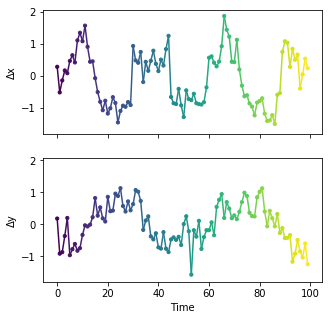

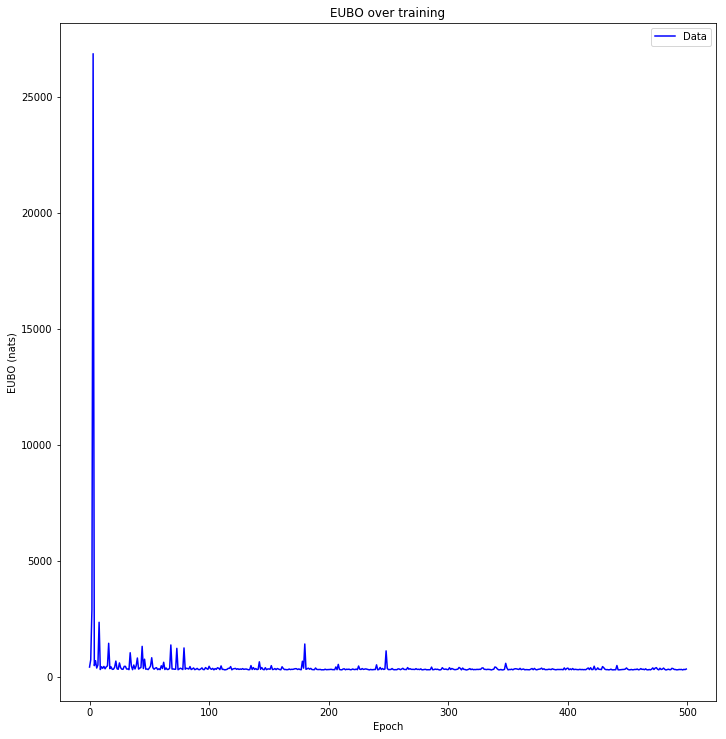

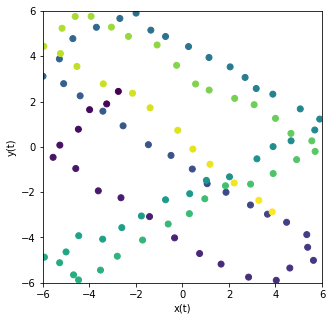

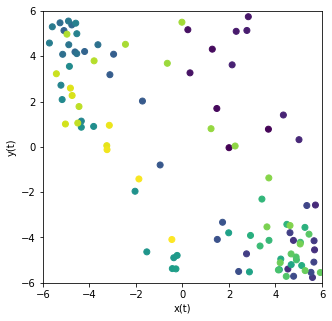

03/05/2019 13:01:47 MSE at time 0: tensor(28.8360)
03/05/2019 13:01:47 MSE at time 1: tensor(49.6376)
03/05/2019 13:01:47 MSE at time 2: tensor(29.9459)
03/05/2019 13:01:47 MSE at time 3: tensor(45.6682)
03/05/2019 13:01:47 MSE at time 4: tensor(56.2784)
03/05/2019 13:01:47 MSE at time 5: tensor(48.5848)
03/05/2019 13:01:47 MSE at time 6: tensor(99.9920)
03/05/2019 13:01:47 MSE at time 7: tensor(84.7535)
03/05/2019 13:01:47 MSE at time 8: tensor(83.8744)
03/05/2019 13:01:47 MSE at time 9: tensor(57.5094)
03/05/2019 13:01:47 MSE at time 10: tensor(51.3155)
03/05/2019 13:01:47 MSE at time 11: tensor(43.5483)
03/05/2019 13:01:47 MSE at time 12: tensor(23.2714)
03/05/2019 13:01:47 MSE at time 13: tensor(2.9819)
03/05/2019 13:01:47 MSE at time 14: tensor(4.5190)
03/05/2019 13:01:47 MSE at time 15: tensor(1.5115)
03/05/2019 13:01:47 MSE at time 16: tensor(0.5734)
03/05/2019 13:01:47 MSE at time 17: tensor(0.1589)
03/05/2019 13:01:47 MSE at time 18: tensor(7.4391)
03/05/2019 13:01:47 MSE at t

Epoch   215: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 13:02:34 EUBO=2.17334579e+02 at epoch 218
03/05/2019 13:02:34 EUBO=2.32100494e+02 at epoch 219
03/05/2019 13:02:34 EUBO=2.48299118e+02 at epoch 220
03/05/2019 13:02:34 EUBO=2.31094788e+02 at epoch 221
03/05/2019 13:02:35 EUBO=1.95966843e+02 at epoch 222
03/05/2019 13:02:35 EUBO=2.32546417e+02 at epoch 223
03/05/2019 13:02:35 EUBO=2.31449341e+02 at epoch 224
03/05/2019 13:02:35 EUBO=2.42257385e+02 at epoch 225
03/05/2019 13:02:35 EUBO=2.11549850e+02 at epoch 226
03/05/2019 13:02:36 EUBO=1.76915894e+02 at epoch 227
03/05/2019 13:02:36 EUBO=2.53307632e+02 at epoch 228
03/05/2019 13:02:36 EUBO=2.32167679e+02 at epoch 229
03/05/2019 13:02:36 EUBO=2.41360413e+02 at epoch 230
03/05/2019 13:02:36 EUBO=2.55872818e+02 at epoch 231
03/05/2019 13:02:37 EUBO=1.98240005e+02 at epoch 232
03/05/2019 13:02:37 EUBO=2.55336899e+02 at epoch 233
03/05/2019 13:02:37 EUBO=2.23401764e+02 at epoch 234
03/05/2019 13:02:37 EUBO=2.37050415e+02 at epoch 235
03/05/2019 13:02:38 EUBO=2.16108093e+02 at epo

Epoch   470: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 13:03:27 EUBO=2.34583115e+02 at epoch 473
03/05/2019 13:03:28 EUBO=2.37550827e+02 at epoch 474
03/05/2019 13:03:28 EUBO=2.45128937e+02 at epoch 475
03/05/2019 13:03:28 EUBO=2.11854797e+02 at epoch 476
03/05/2019 13:03:28 EUBO=2.40191055e+02 at epoch 477
03/05/2019 13:03:28 EUBO=2.06598145e+02 at epoch 478
03/05/2019 13:03:29 EUBO=2.06174454e+02 at epoch 479
03/05/2019 13:03:29 EUBO=1.95323166e+02 at epoch 480
03/05/2019 13:03:29 EUBO=2.05347153e+02 at epoch 481
03/05/2019 13:03:29 EUBO=1.97481079e+02 at epoch 482
03/05/2019 13:03:29 EUBO=2.18765732e+02 at epoch 483
03/05/2019 13:03:30 EUBO=2.06918945e+02 at epoch 484
03/05/2019 13:03:30 EUBO=2.09601593e+02 at epoch 485
03/05/2019 13:03:30 EUBO=1.93303024e+02 at epoch 486
03/05/2019 13:03:30 EUBO=2.25395340e+02 at epoch 487
03/05/2019 13:03:30 EUBO=2.03185287e+02 at epoch 488
03/05/2019 13:03:30 EUBO=1.92800949e+02 at epoch 489
03/05/2019 13:03:31 EUBO=1.89208023e+02 at epoch 490
03/05/2019 13:03:31 EUBO=1.90753006e+02 at epo

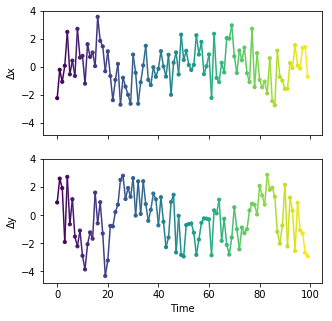

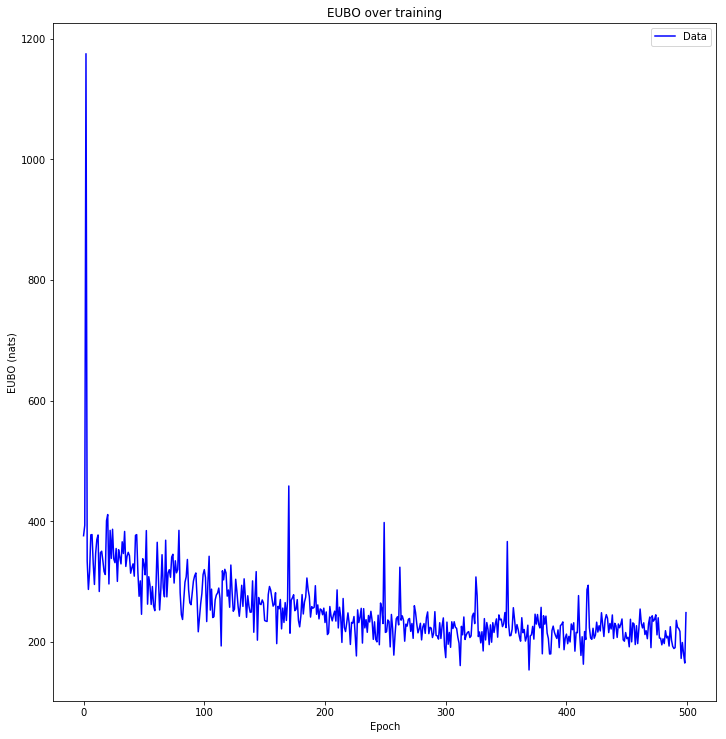

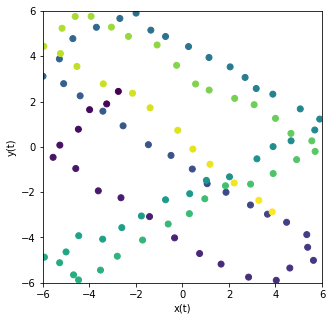

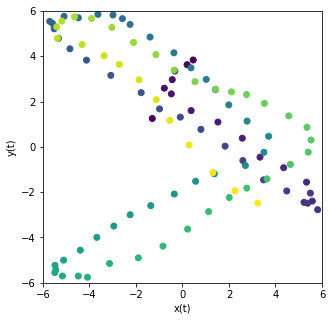

03/05/2019 13:03:33 MSE at time 0: tensor(3.5607)
03/05/2019 13:03:33 MSE at time 1: tensor(17.6035)
03/05/2019 13:03:33 MSE at time 2: tensor(21.5328)
03/05/2019 13:03:33 MSE at time 3: tensor(23.8161)
03/05/2019 13:03:33 MSE at time 4: tensor(31.7390)
03/05/2019 13:03:33 MSE at time 5: tensor(32.1967)
03/05/2019 13:03:33 MSE at time 6: tensor(27.7591)
03/05/2019 13:03:33 MSE at time 7: tensor(28.4746)
03/05/2019 13:03:33 MSE at time 8: tensor(28.5559)
03/05/2019 13:03:33 MSE at time 9: tensor(27.8975)
03/05/2019 13:03:33 MSE at time 10: tensor(26.1953)
03/05/2019 13:03:33 MSE at time 11: tensor(27.4331)
03/05/2019 13:03:33 MSE at time 12: tensor(26.6079)
03/05/2019 13:03:33 MSE at time 13: tensor(18.7859)
03/05/2019 13:03:33 MSE at time 14: tensor(13.2885)
03/05/2019 13:03:33 MSE at time 15: tensor(8.0652)
03/05/2019 13:03:33 MSE at time 16: tensor(6.4205)
03/05/2019 13:03:33 MSE at time 17: tensor(5.7293)
03/05/2019 13:03:33 MSE at time 18: tensor(4.4518)
03/05/2019 13:03:33 MSE at 

Epoch   200: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 13:04:23 EUBO=2.02487335e+02 at epoch 203
03/05/2019 13:04:23 EUBO=3.71411163e+02 at epoch 204
03/05/2019 13:04:24 EUBO=2.84198364e+02 at epoch 205
03/05/2019 13:04:24 EUBO=4.01122742e+02 at epoch 206
03/05/2019 13:04:24 EUBO=1.55570694e+02 at epoch 207
03/05/2019 13:04:25 EUBO=2.98993896e+02 at epoch 208
03/05/2019 13:04:25 EUBO=2.10232559e+02 at epoch 209
03/05/2019 13:04:25 EUBO=1.61771713e+02 at epoch 210
03/05/2019 13:04:25 EUBO=3.17475708e+02 at epoch 211
03/05/2019 13:04:26 EUBO=3.55800385e+02 at epoch 212
03/05/2019 13:04:26 EUBO=3.80063934e+02 at epoch 213
03/05/2019 13:04:26 EUBO=3.25275604e+02 at epoch 214
03/05/2019 13:04:26 EUBO=3.51676758e+02 at epoch 215
03/05/2019 13:04:27 EUBO=3.06215332e+02 at epoch 216
03/05/2019 13:04:27 EUBO=1.67982147e+02 at epoch 217
03/05/2019 13:04:27 EUBO=2.19402557e+02 at epoch 218
03/05/2019 13:04:27 EUBO=3.98248383e+02 at epoch 219
03/05/2019 13:04:28 EUBO=4.59741486e+02 at epoch 220
03/05/2019 13:04:28 EUBO=2.33062393e+02 at epo

Epoch   301: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 13:04:48 EUBO=2.30873138e+02 at epoch 303
03/05/2019 13:04:48 EUBO=3.15105865e+02 at epoch 304
03/05/2019 13:04:48 EUBO=3.04549835e+02 at epoch 305
03/05/2019 13:04:49 EUBO=2.33666641e+02 at epoch 306
03/05/2019 13:04:49 EUBO=4.93728394e+02 at epoch 307
03/05/2019 13:04:49 EUBO=3.30134033e+02 at epoch 308
03/05/2019 13:04:50 EUBO=3.88223236e+02 at epoch 309
03/05/2019 13:04:50 EUBO=3.91879303e+02 at epoch 310
03/05/2019 13:04:50 EUBO=2.24663712e+02 at epoch 311
03/05/2019 13:04:50 EUBO=3.48594879e+02 at epoch 312
03/05/2019 13:04:51 EUBO=2.33025497e+02 at epoch 313
03/05/2019 13:04:51 EUBO=4.05234833e+02 at epoch 314
03/05/2019 13:04:51 EUBO=4.05943878e+02 at epoch 315
03/05/2019 13:04:52 EUBO=2.39652008e+02 at epoch 316
03/05/2019 13:04:52 EUBO=3.42245209e+02 at epoch 317
03/05/2019 13:04:52 EUBO=2.76354858e+02 at epoch 318
03/05/2019 13:04:52 EUBO=3.24211761e+02 at epoch 319
03/05/2019 13:04:53 EUBO=3.58194061e+02 at epoch 320
03/05/2019 13:04:53 EUBO=3.48951202e+02 at epo

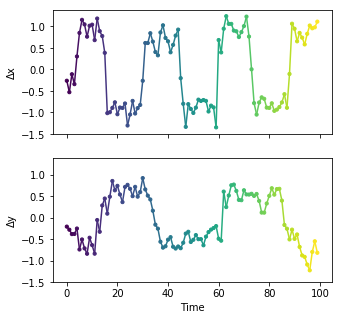

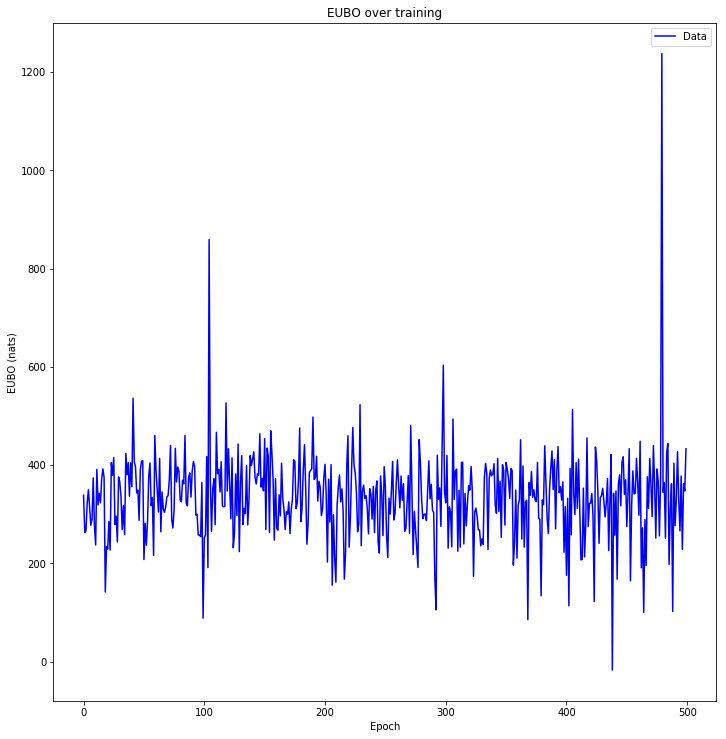

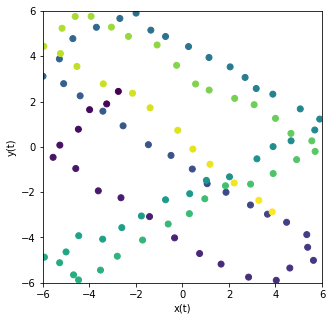

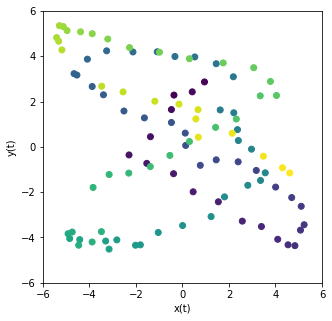

03/05/2019 13:05:38 MSE at time 0: tensor(5.7493)
03/05/2019 13:05:38 MSE at time 1: tensor(18.6397)
03/05/2019 13:05:38 MSE at time 2: tensor(20.1076)
03/05/2019 13:05:38 MSE at time 3: tensor(16.7692)
03/05/2019 13:05:38 MSE at time 4: tensor(15.3265)
03/05/2019 13:05:38 MSE at time 5: tensor(10.6749)
03/05/2019 13:05:38 MSE at time 6: tensor(9.3860)
03/05/2019 13:05:38 MSE at time 7: tensor(11.0443)
03/05/2019 13:05:38 MSE at time 8: tensor(9.7029)
03/05/2019 13:05:38 MSE at time 9: tensor(9.1842)
03/05/2019 13:05:38 MSE at time 10: tensor(9.0310)
03/05/2019 13:05:38 MSE at time 11: tensor(8.4957)
03/05/2019 13:05:38 MSE at time 12: tensor(7.1367)
03/05/2019 13:05:38 MSE at time 13: tensor(4.9174)
03/05/2019 13:05:38 MSE at time 14: tensor(2.9831)
03/05/2019 13:05:38 MSE at time 15: tensor(3.0105)
03/05/2019 13:05:38 MSE at time 16: tensor(2.6321)
03/05/2019 13:05:38 MSE at time 17: tensor(3.3525)
03/05/2019 13:05:38 MSE at time 18: tensor(3.0951)
03/05/2019 13:05:38 MSE at time 19:

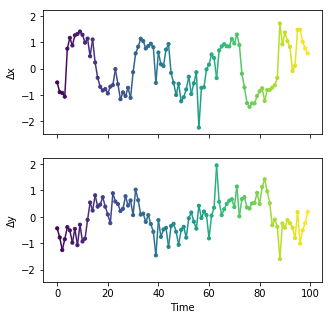

In [24]:
results_dict = experiment()

In [25]:
torch.save(results_dict, 'examples/dynamical_ball/experiment_results.data')